# Manejo de datos faltantes

Es importante conocer el qué hacer con este tipo de datos y cómo detectarlos, ya que en la práctica es muy común encontrar datos incompleto, ignorar los valores faltantes puede introducir sesgos en tu analisis y modelo.

Multiple de los algoritmos disponibles fallaran. Los algoritmos no saben lidiar con los valores faltantes por lo que terminaran eliminadolo.

La mejor manera de tratar los datos que faltan es no tenerlos, pero la realidad es que muchos conjuntos de datos van a tener valores faltantes por lo que debes saber tratarlos y entenderlos.

## Librerías

In [99]:
import pandas as pd
import janitor
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import numpy as np
import pyreadr
import session_info
import upsetplot
import pandas_missing

In [100]:
%matplotlib inline

sns.set(
    rc = {
        "figure.figsize": (10, 10)
    }
)
sns.set_style("whitegrid")

## Operar con valores faltantes

### Python

In [101]:
print(
    type(None),
    None or True,
    None or False,
    None == None,
    None is None,
    # None + 3, # Error
    sep = "\n"
)

<class 'NoneType'>
True
False
True
True


### Numpy

In [102]:
print(
    type(np.nan),
    np.nan or True,
    np.nan == np.nan,
    np.nan is np.nan,
    np.nan / 2,
    np.isnan(np.nan),
    sep = "\n"
)

<class 'float'>
nan
False
True
nan
True


### Pandas

In [103]:
test_missing_df = pd.DataFrame.from_dict(
    data=dict(
        x=[0, 1, np.nan, np.nan, None],
        y=[0, 1, pd.NA, np.nan, None]
    )
)
test_missing_df

,x,y
0,0.0,0
1,1.0,1
2,NaN,<NA>
3,NaN,NaN
4,NaN,None


In [104]:
test_missing_df.isnull()

,x,y
0,False,False
1,False,False
2,True,True
3,True,True
4,True,True


## Trabajando con un dataset

In [105]:
# Descargar datos
import urllib.request
url = "https://nrvis.com/data/mldata/pima-indians-diabetes.csv"
filename = "./data/pima-indians-diabetes.csv"
urllib.request.urlretrieve(url, filename)

('./data/pima-indians-diabetes.csv',
 <http.client.HTTPMessage at 0x1e6fc58ee10>)

In [106]:
diabetes_df = pd.read_csv(
    filename,
    sep=",",
    names=[
        "pregnancies",
        "glucose",
        "blood_pressure",
        "skin_thickness",
        "insulin",
        "bmi",
        "diabetes_pedigree_function",
        "age",
        "outcome",
    ]
)
diabetes_df

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [107]:
#Guarda la URL en una variable
base_url = "https://github.com/njtierney/naniar/raw/master/data/"
#Guarda los nombres de los archivos a descargar en una lista 
datasets_names = ("oceanbuoys", "pedestrian", "riskfactors")
#Guarda la extension de los archivos en una variable
extension = ".rda"

In [108]:
datasets_dfs = {} # diccionario para almacenar lor archivos

for dataset_name in datasets_names:

    dataset_file = f"{ dataset_name }{ extension }"
    dataset_output_file = f"./data/{ dataset_file }"
    dataset_url = f"{ base_url }{ dataset_file }"
    
    urllib.request.urlretrieve(dataset_url, dataset_output_file)
    datasets_dfs[f"{ dataset_name }_df"] = pyreadr.read_r(dataset_output_file).get(dataset_name)

datasets_dfs.keys()

dict_keys(['oceanbuoys_df', 'pedestrian_df', 'riskfactors_df'])

In [109]:
list(datasets_dfs.keys())

['oceanbuoys_df', 'pedestrian_df', 'riskfactors_df']

In [110]:
oceanbuoys_df = datasets_dfs[list(datasets_dfs.keys())[0]]
pedestrian_df = datasets_dfs[list(datasets_dfs.keys())[1]]
riskfactors_df = datasets_dfs[list(datasets_dfs.keys())[2]]

In [111]:
locals().update(**datasets_dfs)
del datasets_dfs

In [112]:
oceanbuoys_df.shape, pedestrian_df.shape, riskfactors_df.shape, diabetes_df.shape

((736, 8), (37700, 9), (245, 34), (768, 9))

### Extender pandas

In [113]:
# @pd.api.extensions.register_dataframe_accessor("missing")  #Decorador
# class MissingMethods:                                      #clase
#     def __init__(self, pandas_obj):
#         self._df = pandas_obj

#     def number_missing(self):                        #metodo para contar datos faltantes
#         return self._df.isna().sum().sum()

#     def number_complet(self):                        #metodo para contar datos completos
#         return self._df.size - self._df.missing.number_missing()
    
#     def summarize_variable_missing(
#         self,
#         sort: bool = True, # Indicate whether to sort the result by `number_missing`.
#         ascending: bool = False ,# Sort ascending vs. descending. Only applicable when sort is `True`.
#         add_cumsum: bool = False # Indicate wheter or not to add the cumulative sum of missings. **Note**: cumsum is calculated based on input data.
#             ) -> pd.DataFrame: # A pandas DataFrame containing the following columns: `variable`, `number_missing`, `proportion_missing`, `percentage_missing`, and optionally`number_missing_cumsum`.
#             """Summarize the missingness in each variable.
#             The summary always includes the number, proportion and percentage of missings.
#             Besides, it could include the cumulative sum of missings.
#             """
#             return (
#                 self._df
#                 .isna()
#                 .sum()
#                 .reset_index(name="number_missing")
#                 .rename(columns={"index": "variable"})
#                 .assign(
#                     proportion_missing=lambda df: df.number_missing / df.number_missing.sum(),
#                     percentage_missing=lambda df: df.proportion_missing * 100        
#                 )
#                 .pipe(
#                     lambda df: df if not add_cumsum else (
#                         df
#                         .assign(
#                         number_missing_cumsum=lambda internal_df: internal_df.number_missing.cumsum()
#                         )
#                     )
#                 )
#                 .pipe(
#                     lambda df: df if not sort else df.sort_values(
#                         by="number_missing",
#                         ascending=ascending
#                     )
#                 )
#             )
#     def tabulate_variable_missing(
#         self,
#         **kwargs # Extra arguments to be passed to `pd.value_counts()` except or `subset`, and `normalize`.
#     ) -> pd.DataFrame: # A pandas DataFrames.
#         """Provide a table of the number of variables with 0, 1, 2, up to `n`, missing values and the proporton and percentage of the number of variables those variables make up."""
        
#         return (
#             self._df
#             .missing.summarize_variable_missing()
#             .value_counts(
#                 subset="number_missing",
#                 normalize=False,
#                 **kwargs
#             )
#             .reset_index(name="number_variables")
#             .assign(
#                 proportion_variables=lambda df: df.number_variables / df.number_variables.sum(),
#                 percentage_variables=lambda df: df.proportion_variables * 100
#             )
#         )

In [114]:

# accediendo al metodo number_missing
print(diabetes_df.missing.number_missing())

#accediendo al metodo number_complet
print(diabetes_df.missing.number_complete())

0
6912


## Tabulación

Las preguntas principales para conocer son:
|||
|---|---|
|¿Cuántos valores faltantes existe por variable|¿Cuántos valores faltantes existen por cada observación|
|¿Cuántas variables tiene X número de valores faltantes   |¿Cuántas observaciones teinen X número de valores faltantes   |


In [115]:
riskfactors_df

,state,sex,age,weight_lbs,height_inch,bmi,marital,pregnant,children,education,...,smoke_100,smoke_days,smoke_stop,smoke_last,diet_fruit,diet_salad,diet_potato,diet_carrot,diet_vegetable,diet_juice
0,26,Female,49,190,64,32.68,Married,NaN,0,6,...,No,NaN,NaN,NaN,1095,261,104,156,521,12
1,40,Female,48,170,68,25.90,Divorced,NaN,0,5,...,No,NaN,NaN,NaN,52,209,52,0,52,0
2,72,Female,55,163,64,28.04,Married,NaN,0,4,...,No,NaN,NaN,NaN,36,156,52,24,24,24
3,42,Male,42,230,74,29.59,Married,NaN,1,6,...,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32,Female,66,135,62,24.74,Widowed,NaN,0,5,...,Yes,Everyday,Yes,NaN,-7,261,209,261,365,104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,10,Female,79,144,63,25.56,Widowed,NaN,0,4,...,No,NaN,NaN,NaN,-7,-7,-7,-7,-7,-7
241,46,Male,45,170,74,21.87,Divorced,NaN,2,4,...,No,NaN,NaN,NaN,52,52,52,24,52,24
242,15,Male,62,175,71,24.46,Divorced,NaN,0,6,...,Yes,Not@All,NaN,7,365,156,104,52,730,365
243,34,Female,62,138,64,23.74,Married,NaN,0,4,...,Yes,Everyday,No,NaN,730,0,24,156,104,0


In [116]:
riskfactors_df.isna()

,state,sex,age,weight_lbs,height_inch,bmi,marital,pregnant,children,education,...,smoke_100,smoke_days,smoke_stop,smoke_last,diet_fruit,diet_salad,diet_potato,diet_carrot,diet_vegetable,diet_juice
0,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,False,False,False,False,False,False
1,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,False,False,False,False,False,False
2,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,False,False,False,False,False,False
3,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,True,True,True,True,True,True
4,False,False,False,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,False,False,False,False,False,False
241,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,False,False,False,False,False,False
242,False,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
243,False,False,False,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False


In [117]:
riskfactors_df.size, riskfactors_df.shape

(8330, (245, 34))

In [118]:
riskfactors_df.missing.number_complete()

7144

In [119]:
riskfactors_df.missing.number_missing()

1186

Resumen  por variable

In [120]:
missing_cant = pd.DataFrame(dict(
    n_missing = riskfactors_df.isna().sum(),
    pct_missing = riskfactors_df.isna().sum() / riskfactors_df.shape[0] * 100
    )).reset_index().rename(columns={"index": "variable"})
missing_cant

,variable,n_missing,pct_missing
0,state,0,0.000000
1,sex,0,0.000000
2,age,0,0.000000
3,weight_lbs,10,4.081633
4,height_inch,2,0.816327
5,bmi,11,4.489796
6,marital,1,0.408163
7,pregnant,215,87.755102
8,children,0,0.000000
9,education,1,0.408163


In [121]:
missing_var = pd.DataFrame(dict(
    n_variables = missing_cant["n_missing"].value_counts(),
    pct_variables = missing_cant["n_missing"].value_counts() / missing_cant.shape[0] * 100
))
missing_var

,n_variables,pct_variables
n_missing,,
0,10,29.411765
8,6,17.647059
2,4,11.764706
3,3,8.823529
1,2,5.882353
10,1,2.941176
11,1,2.941176
215,1,2.941176
113,1,2.941176


In [122]:
missing_row = pd.DataFrame(
    dict(
        n_missing = riskfactors_df.isna().sum(axis=1),
        pct_missing = riskfactors_df.isna().sum(axis=1) / (len(riskfactors_df.columns))
    )
)
missing_row

,n_missing,pct_missing
0,6,0.176471
1,6,0.176471
2,7,0.205882
3,12,0.352941
4,5,0.147059
...,...,...
240,6,0.176471
241,5,0.147059
242,3,0.088235
243,2,0.058824


In [123]:
missing_row.groupby(by="n_missing").count().reset_index()["n_missing"]

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    15
Name: n_missing, dtype: int64

In [124]:
pd.DataFrame(
    dict(
    n_cases = missing_row.groupby(by="n_missing").count().reset_index()["n_missing"],
    pct_cases = missing_row.groupby(by="n_missing").count().reset_index()["n_missing"] / missing_row.shape[0] * 100
    )
)

,n_cases,pct_cases
0,1,0.408163
1,2,0.816327
2,3,1.224490
3,4,1.632653
4,5,2.040816
5,6,2.448980
6,7,2.857143
7,8,3.265306
8,9,3.673469
9,10,4.081633


## Visualización

In [125]:
riskfactors_df.isna()

,state,sex,age,weight_lbs,height_inch,bmi,marital,pregnant,children,education,...,smoke_100,smoke_days,smoke_stop,smoke_last,diet_fruit,diet_salad,diet_potato,diet_carrot,diet_vegetable,diet_juice
0,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,False,False,False,False,False,False
1,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,False,False,False,False,False,False
2,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,False,False,False,False,False,False
3,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,True,True,True,True,True,True
4,False,False,False,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,False,False,False,False,False,False
241,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,False,False,False,False,False,False
242,False,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
243,False,False,False,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False


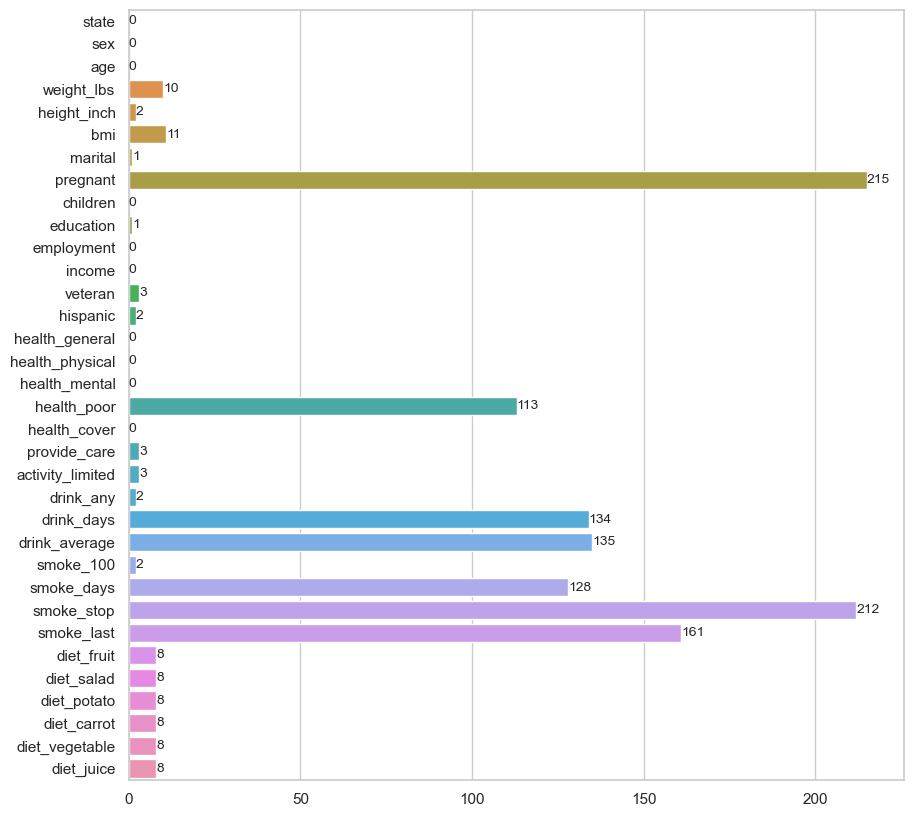

In [126]:
ax = sns.barplot(data=riskfactors_df.isna(),
            orient="h",
            errorbar=None,
            estimator="sum")
ax.bar_label(ax.containers[0], fontsize=10);

<Axes: xlabel='n_missing', ylabel='Count'>

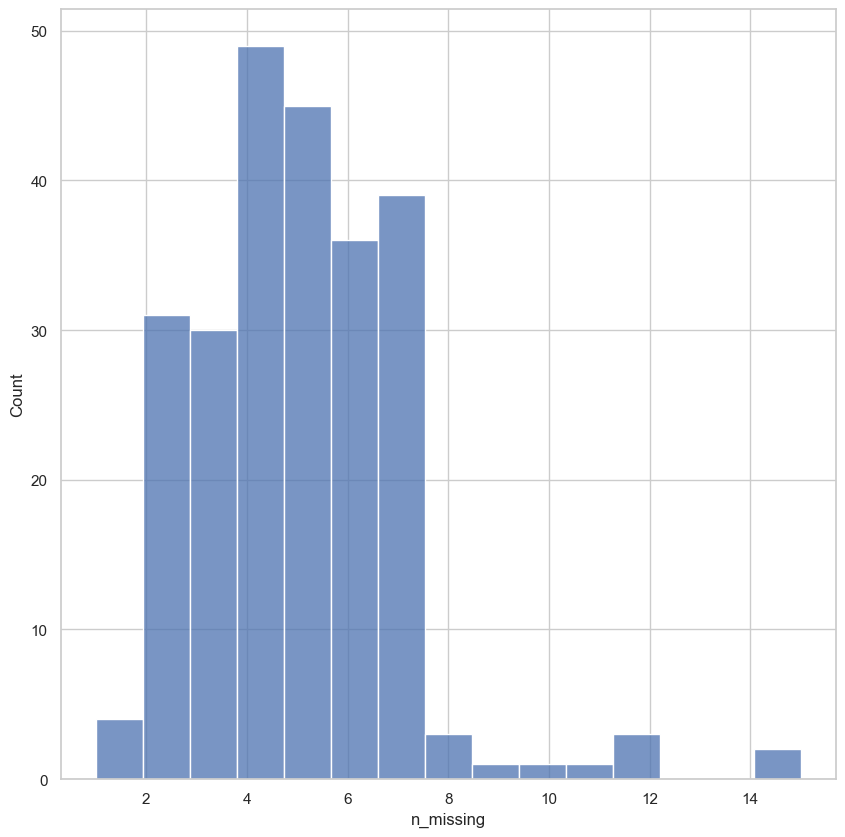

In [127]:
sns.histplot(data=missing_row,
             x="n_missing")

<Axes: >

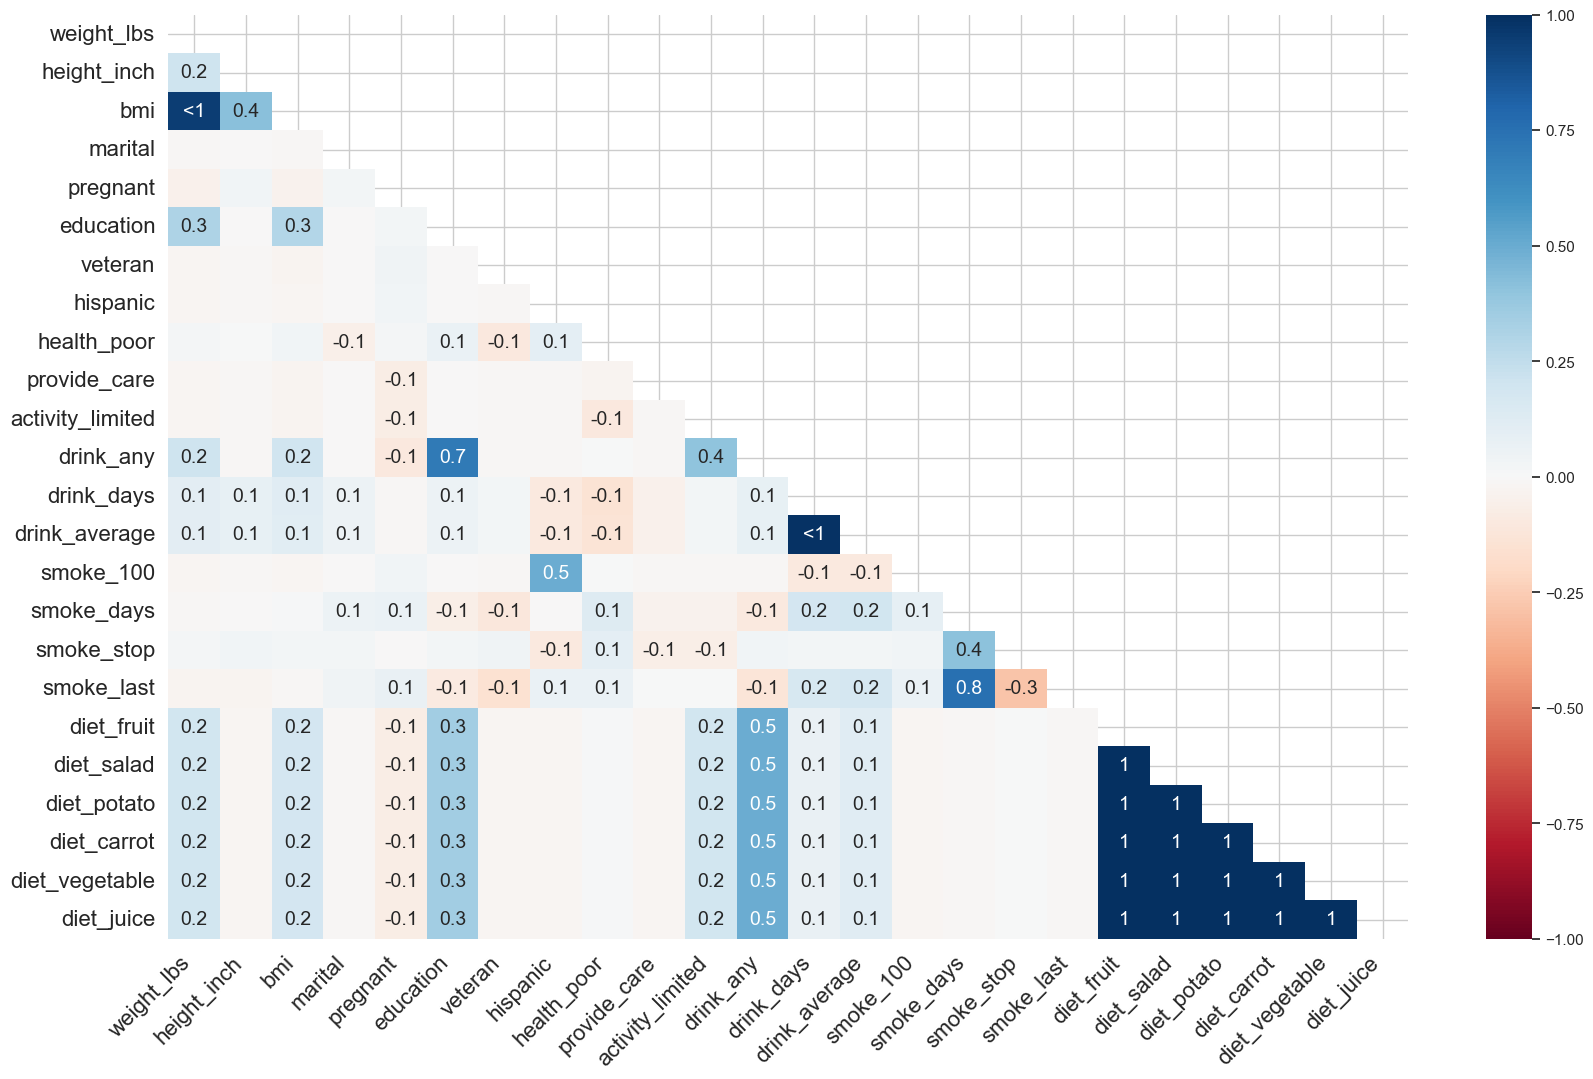

In [128]:
missingno.heatmap(riskfactors_df)

<Axes: >

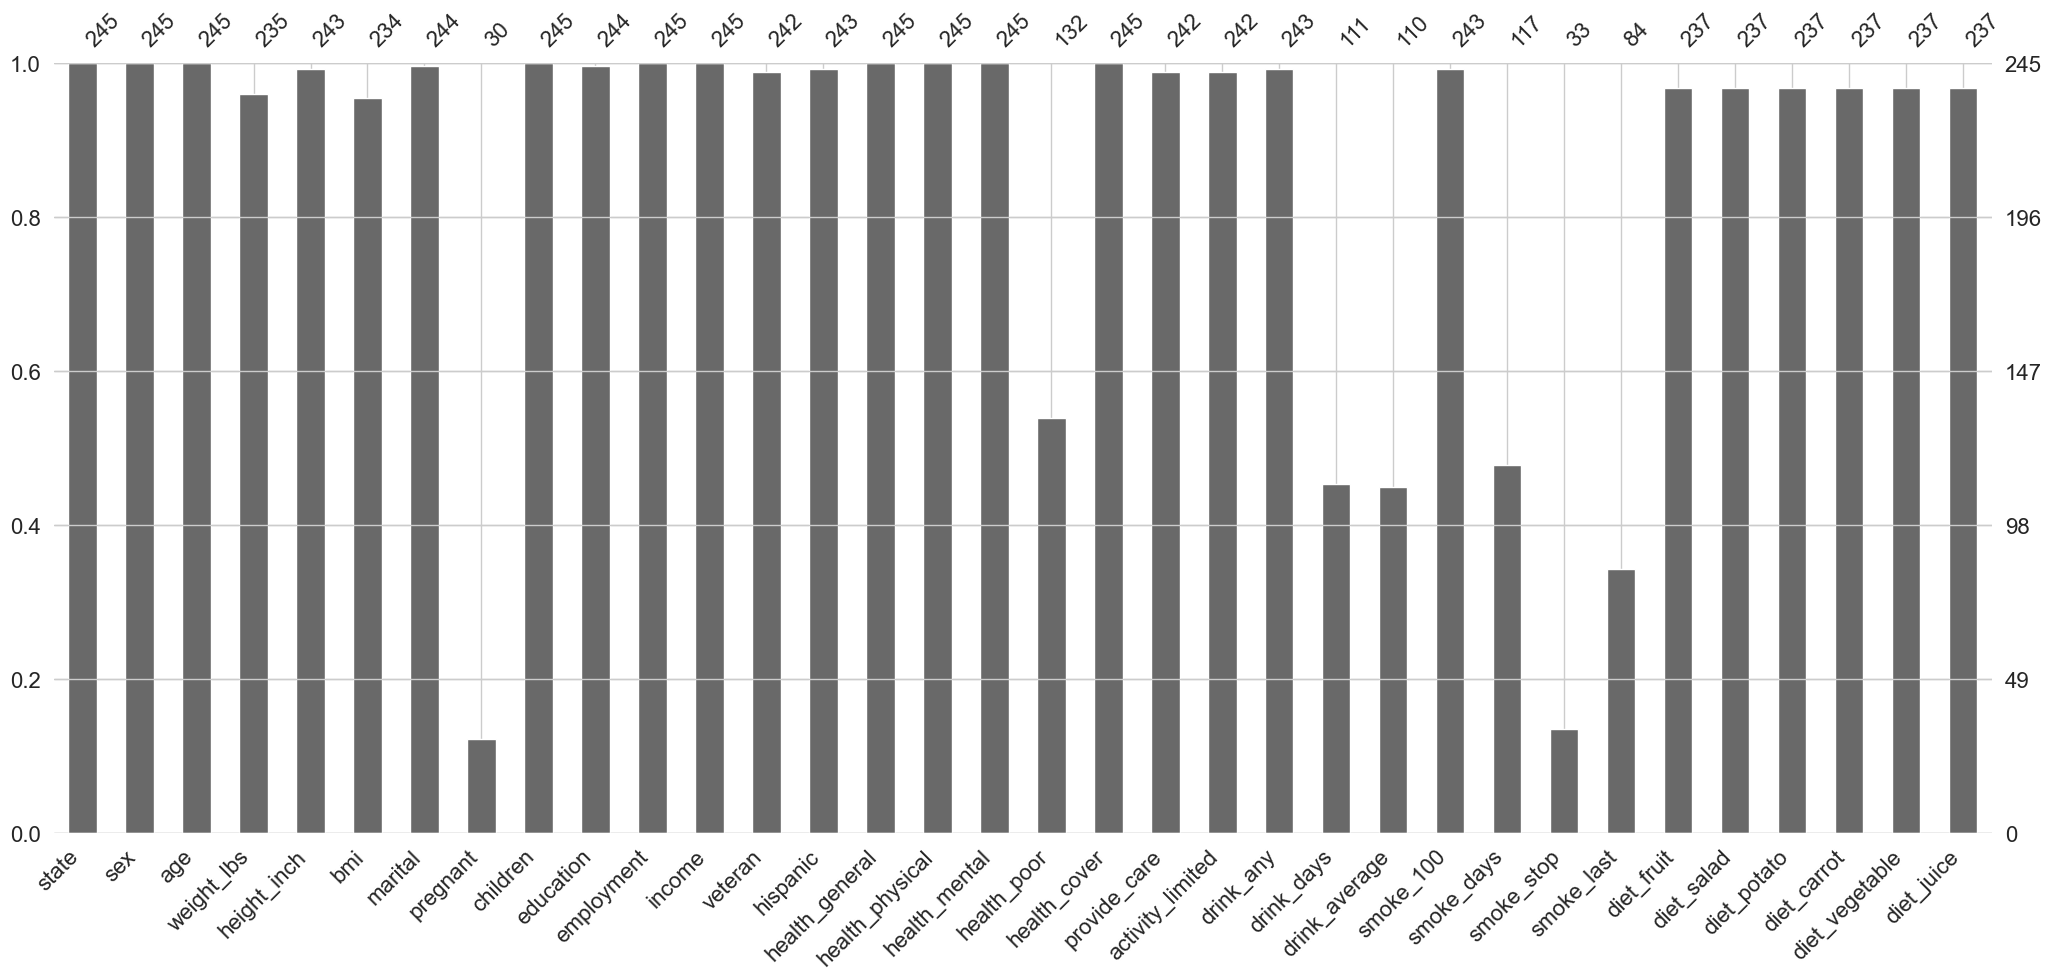

In [129]:
missingno.bar(riskfactors_df)

<Axes: >

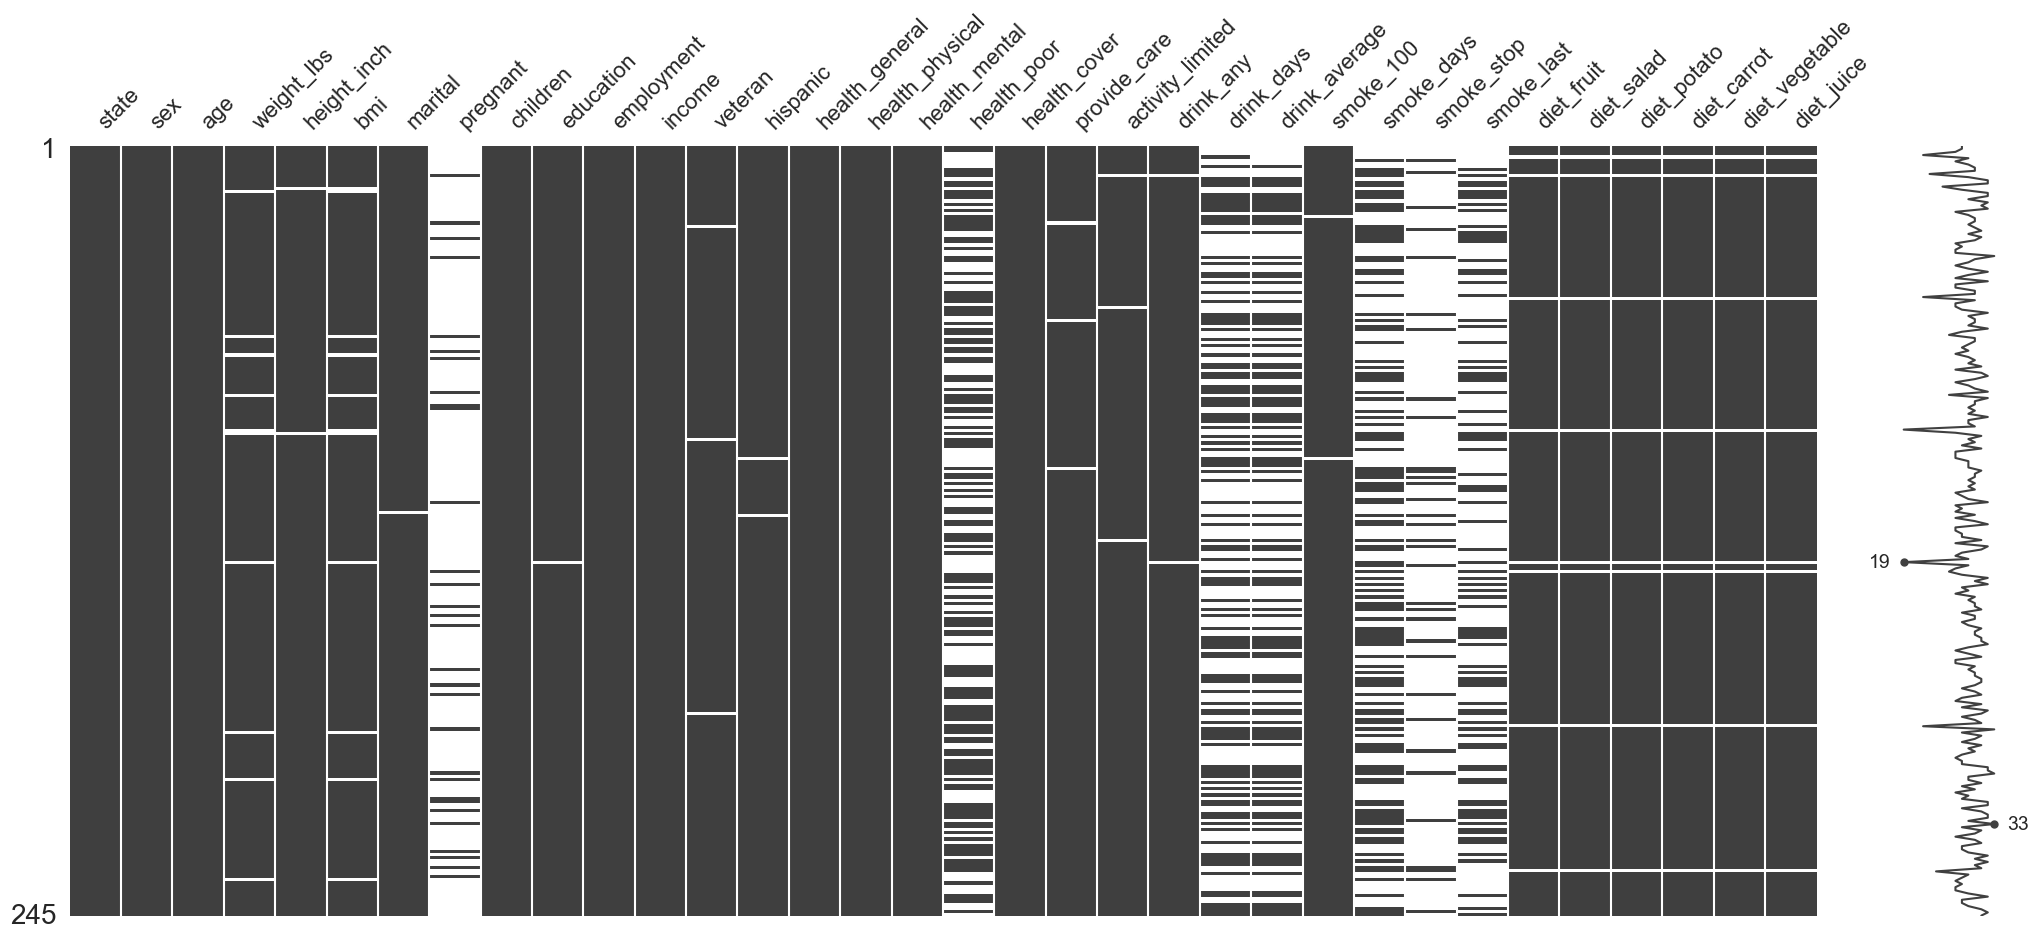

In [130]:
missingno.matrix(riskfactors_df)

In [131]:
riskfactors_df["pregnant"].value_counts()

pregnant
No     28
Yes     2
Name: count, dtype: int64

## Codificación de valores faltantes

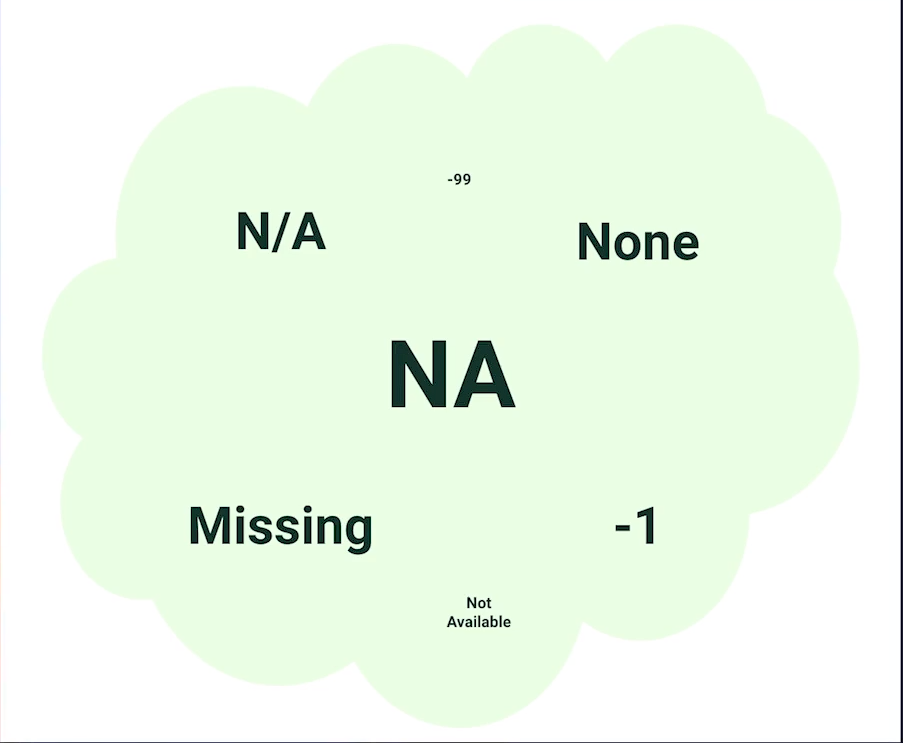

In [132]:
common_na_strings = (
    "missing",
    "NA",
    "N A",
    "N/A",
    "#N/A",
    "NA ",
    " NA",
    "N /A",
    "N / A",
    " N / A",
    "N / A ",
    "na",
    "n a",
    "n/a",
    "na ",
    " na",
    "n /a",
    "n / a",
    " a / a",
    "n / a ",
    "NULL",
    "null",
    "",
    "?",
    "*",
    ".",
)

common_na_numbers = (-9, -99, -999, -9999, 9999, 66, 77, 88, -1)

In [133]:
missing_data_example_df = pd.DataFrame.from_dict(
    dict(
        x = [1, 3, "NA", -99, -98, -99],
        y = ["A", "N/A", "NA", "E", "F", "G"],
        z = [-100, -99, -98, -101, -1, -1]
    )
)

missing_data_example_df

,x,y,z
0,1,A,-100
1,3,N/A,-99
2,NA,NA,-98
3,-99,E,-101
4,-98,F,-1
5,-99,G,-1


In [134]:
missing_data_example_df.dtypes

x    object
y    object
z     int64
dtype: object

In [135]:
(
    missing_data_example_df
    .select_dtypes(object)
    .apply(pd.unique)
)

x     [1, 3, NA, -99, -98]
y    [A, N/A, NA, E, F, G]
dtype: object

## Sustitución

In [136]:
pd.read_csv(
    './data/missing_data_enconding_example.csv',
    na_filter=True,
    na_values=[-99, -1]
)

,x,y,z
0,1.0,A,-100.0
1,3.0,NaN,NaN
2,NaN,NaN,-98.0
3,NaN,E,-101.0
4,-98.0,F,NaN
5,NaN,G,NaN


In [137]:
(
    missing_data_example_df
    .replace(
        to_replace=[-99, 'NA', 'N/A'],
        value= np.nan
    )
)

,x,y,z
0,1.0,A,-100.0
1,3.0,NaN,NaN
2,NaN,NaN,-98.0
3,NaN,E,-101.0
4,-98.0,F,-1.0
5,NaN,G,-1.0


In [138]:
(
    missing_data_example_df
    .replace(
        to_replace={
            'x':{
                -99:np.nan
            }
        }
    )
)
# Sustituye los valores -99 por nan solo en la variable x del dataframe

,x,y,z
0,1,A,-100
1,3,N/A,-99
2,NA,NA,-98
3,NaN,E,-101
4,-98,F,-1
5,NaN,G,-1


### De valores faltantes implícitos a explícitos

Un valor implícito indica que el valor faltante debe estar en el dataset sin que diga que lo esté, por lo general podemos encontrar al pivotar nuestros datos o contabilizar apariciones de combinaciones

In [139]:
implicit_to_explicit_df = pd.DataFrame.from_dict(
    data={
        "name": ["lynn", "lynn", "lynn", "zelda"],
        "time": ["morning", "afternoon", "night", "morning"],
        "value": [350, 310, np.nan, 320]
    }
)
# np.nan es explicito
implicit_to_explicit_df

,name,time,value
0,lynn,morning,350.0
1,lynn,afternoon,310.0
2,lynn,night,NaN
3,zelda,morning,320.0


#### Pivotar tabla

En este caso se observan dos valores faltantes que en un principio no se veían

In [140]:
(
    implicit_to_explicit_df
    .pivot(
        index="name",
        columns="time",
        values="value"
    )
)

time,afternoon,morning,night
name,,,
lynn,310.0,350.0,NaN
zelda,NaN,320.0,NaN


#### Ocurrencia de n-tuplas

In [141]:
(
    implicit_to_explicit_df
    .value_counts(
        subset=["name"] # Cuenta valores asociados a los nombres
    )
    .reset_index(name="n")
)

,name,n
0,lynn,3
1,zelda,1


#### Rellenar datos faltantes

In [142]:
# Rellena los datos faltantes que le indiquemos
(
    implicit_to_explicit_df
    # janitor
    .complete(
        "name",
        "time"
    )
)
janitor.complete(
    implicit_to_explicit_df,
    "name",
    "time"
)

,name,time,value
0,lynn,morning,350.0
1,lynn,afternoon,310.0
2,lynn,night,NaN
3,zelda,morning,320.0
4,zelda,afternoon,NaN
5,zelda,night,NaN


In [143]:
# limitar los datos que quieres mostrar
(
    implicit_to_explicit_df
    .complete( # Formato diccionario con las variables y valores a mostrar
        {'name': ['lynn', 'zelda']},
        {'time': ['morning', 'afternoon']},
        sort=True # Si es true ordena los valores de manera que primero muestra los pasados y luego el resto
    )
)

,name,time,value
0,lynn,afternoon,310.0
1,lynn,morning,350.0
2,zelda,afternoon,NaN
3,zelda,morning,320.0
4,lynn,night,NaN


In [144]:
(
    implicit_to_explicit_df
    .complete(
        'name',
        'time',
        fill_value= "Desconocido"  # puedes asignar el valor que desees. Por defecto asigna nan
    )
)

,name,time,value
0,lynn,morning,350.0
1,lynn,afternoon,310.0
2,lynn,night,Desconocido
3,zelda,morning,320.0
4,zelda,afternoon,Desconocido
5,zelda,night,Desconocido


In [145]:
(
    implicit_to_explicit_df
    .complete(
        'name',
        'time',
        fill_value=0,
        explicit=False # Si es false, solo afecta a las nuevas filas
    )
)

,name,time,value
0,lynn,morning,350.0
1,lynn,afternoon,310.0
2,lynn,night,NaN
3,zelda,morning,320.0
4,zelda,afternoon,0.0
5,zelda,night,0.0


## Tipos de valores faltantes

In [156]:
diabetes_df = pd.read_csv(
    filename,
    sep=",",
    names=[
        "pregnancies",
        "glucose",
        "blood_pressure",
        "skin_thickness",
        "insulin",
        "bmi",
        "diabetes_pedigree_function",
        "age",
        "outcome",
    ]
)
diabetes_df

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [157]:
diabetes_df.isna().sum()

pregnancies                   0
glucose                       0
blood_pressure                0
skin_thickness                0
insulin                       0
bmi                           0
diabetes_pedigree_function    0
age                           0
outcome                       0
dtype: int64

In [158]:
# Solucionar
diabetes_df[diabetes_df.columns[1:6]] = diabetes_df[diabetes_df.columns[1:6]].replace(0,np.nan)
diabetes_df.isna().sum()

pregnancies                     0
glucose                         5
blood_pressure                 35
skin_thickness                227
insulin                       374
bmi                            11
diabetes_pedigree_function      0
age                             0
outcome                         0
dtype: int64

In [167]:
# Obtener la cantidad de valores faltantes por columna
missing_values = diabetes_df.isnull().sum()

# Ordenar las columnas por la cantidad de valores faltantes de mayor a menor
sorted_columns = missing_values.sort_values(ascending=False).index

# Reordenar las columnas del DataFrame
diabetes_df = diabetes_df[sorted_columns]

diabetes_df

,insulin,skin_thickness,blood_pressure,bmi,glucose,pregnancies,diabetes_pedigree_function,age,outcome
0,NaN,35.0,72.0,33.6,148.0,6,0.627,50,1
1,NaN,29.0,66.0,26.6,85.0,1,0.351,31,0
2,NaN,NaN,64.0,23.3,183.0,8,0.672,32,1
3,94.0,23.0,66.0,28.1,89.0,1,0.167,21,0
4,168.0,35.0,40.0,43.1,137.0,0,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,180.0,48.0,76.0,32.9,101.0,10,0.171,63,0
764,NaN,27.0,70.0,36.8,122.0,2,0.340,27,0
765,112.0,23.0,72.0,26.2,121.0,5,0.245,30,0
766,NaN,NaN,60.0,30.1,126.0,1,0.349,47,1


<Axes: >

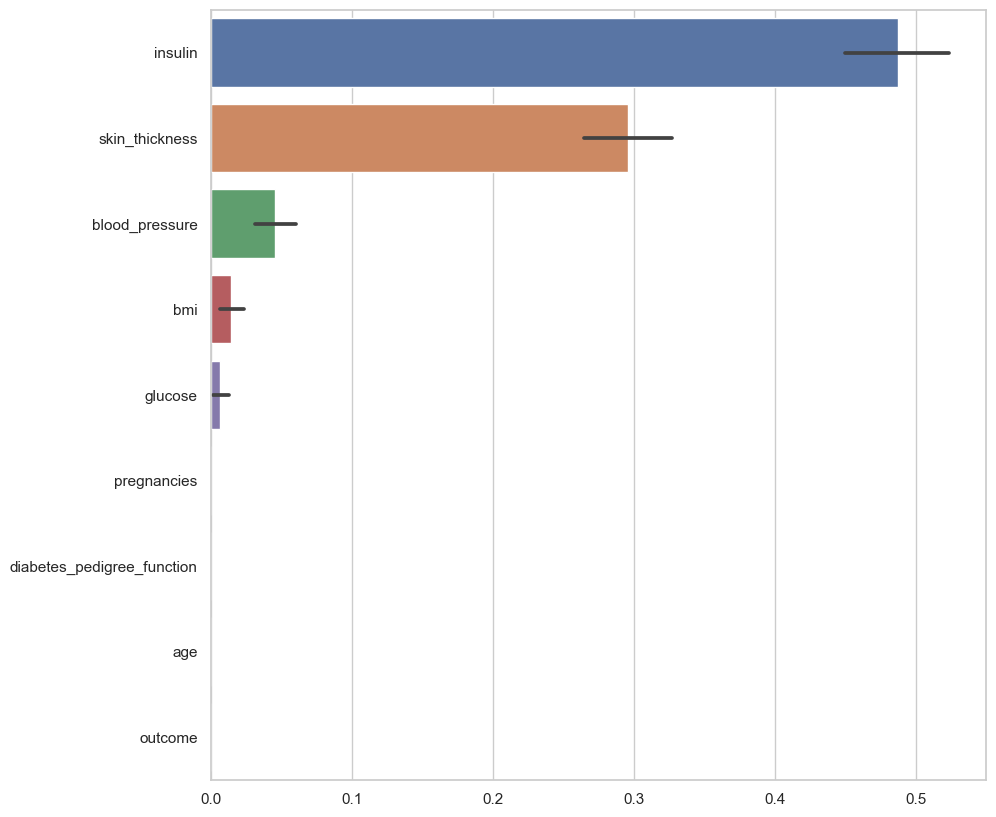

In [168]:
sns.barplot(
    diabetes_df.isna(),
    orient="h"
)

### Missing Completely at Random (MCAR)

Sucede cuando la herramienta de medición falla, esto ocurre completamente al azar

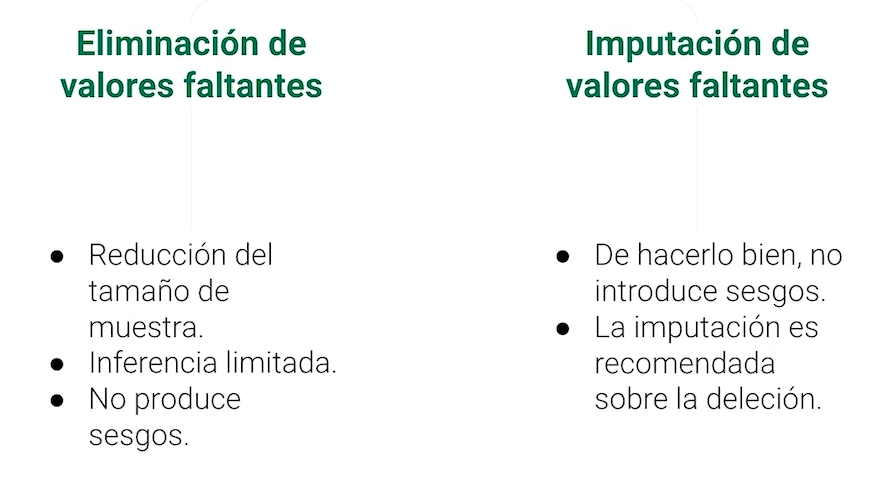

<Axes: >

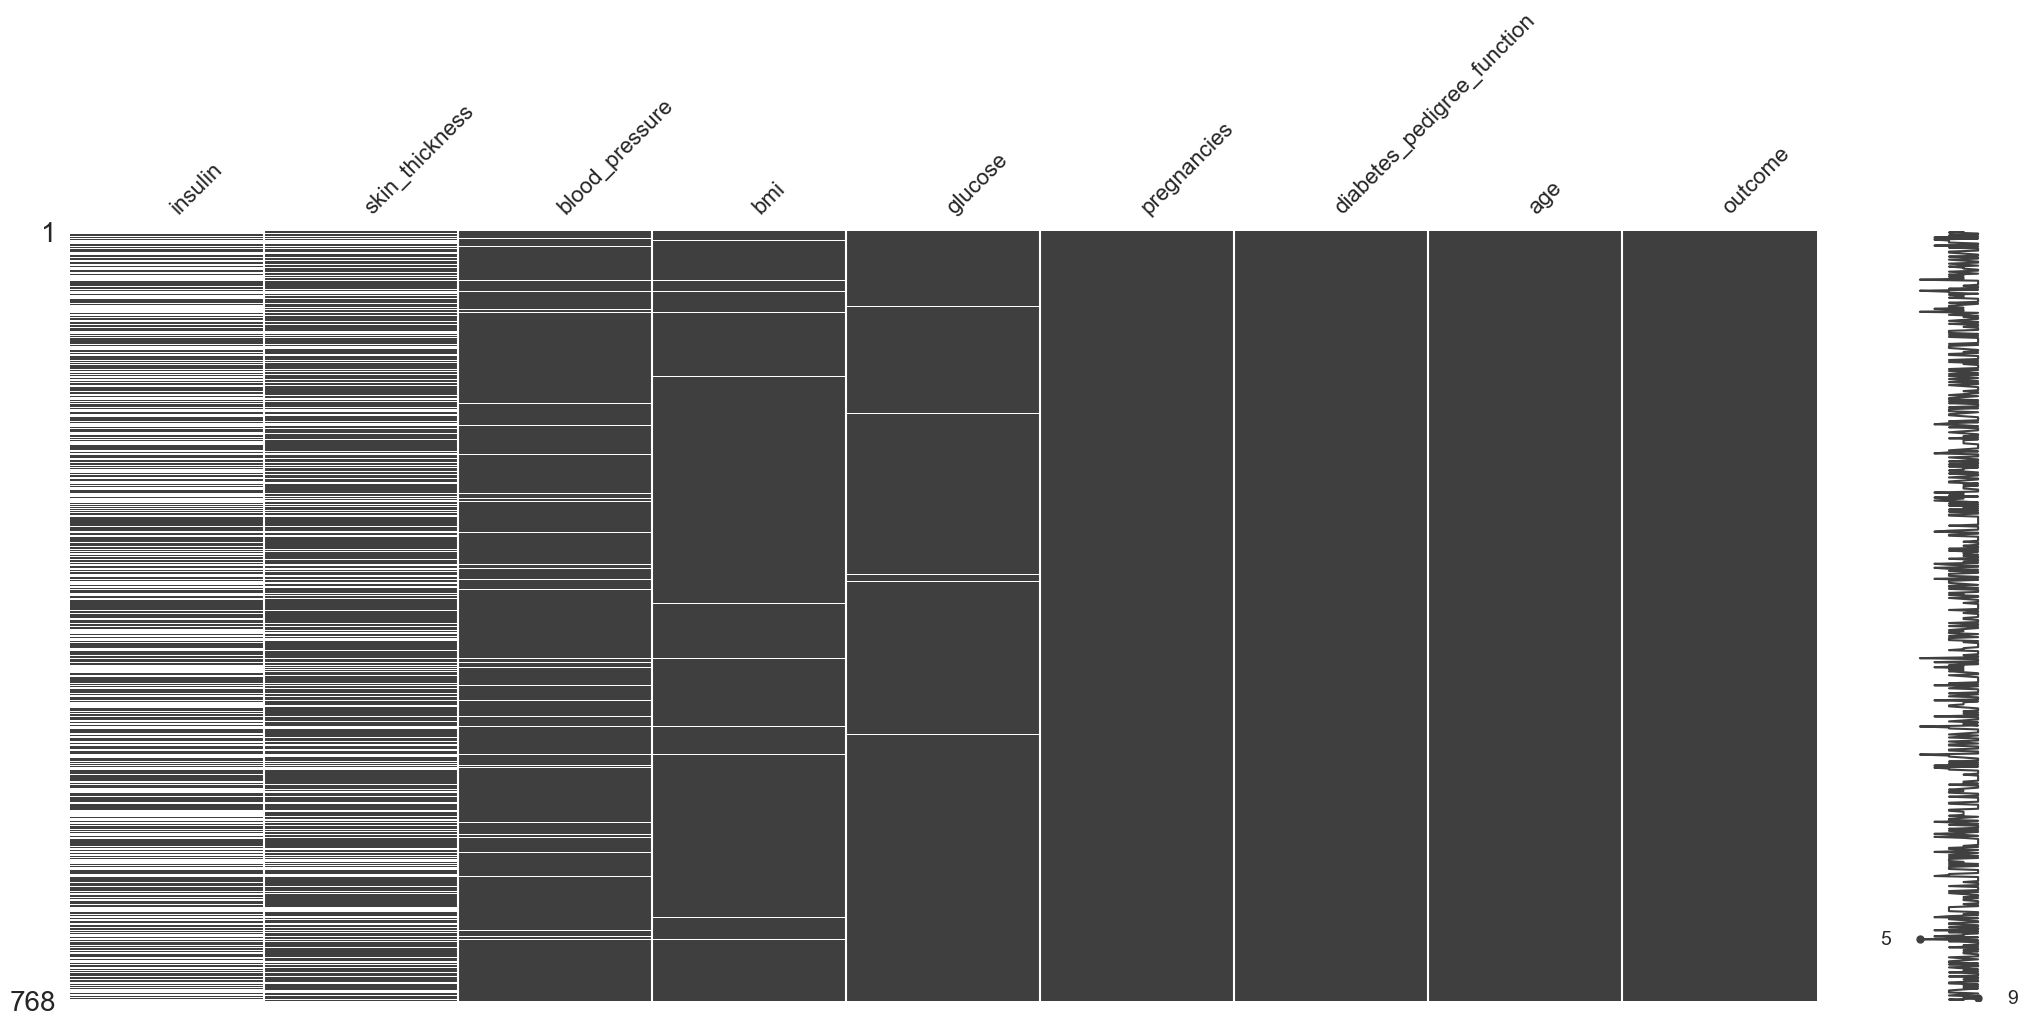

In [169]:
missingno.matrix(diabetes_df)

### Missing at Random (MAR)

Sucede cuando la herramienta necesita mantenimiento y no puede tomar datos en un rango de tiempo o dada otra carácteristica

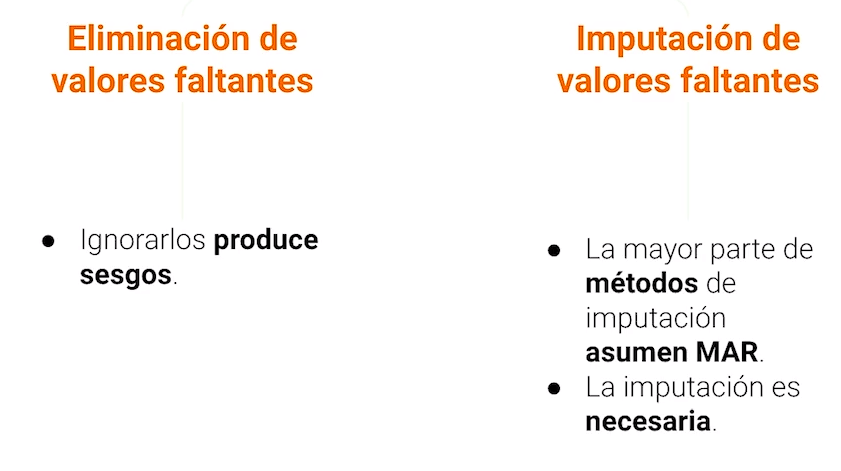

<Axes: >

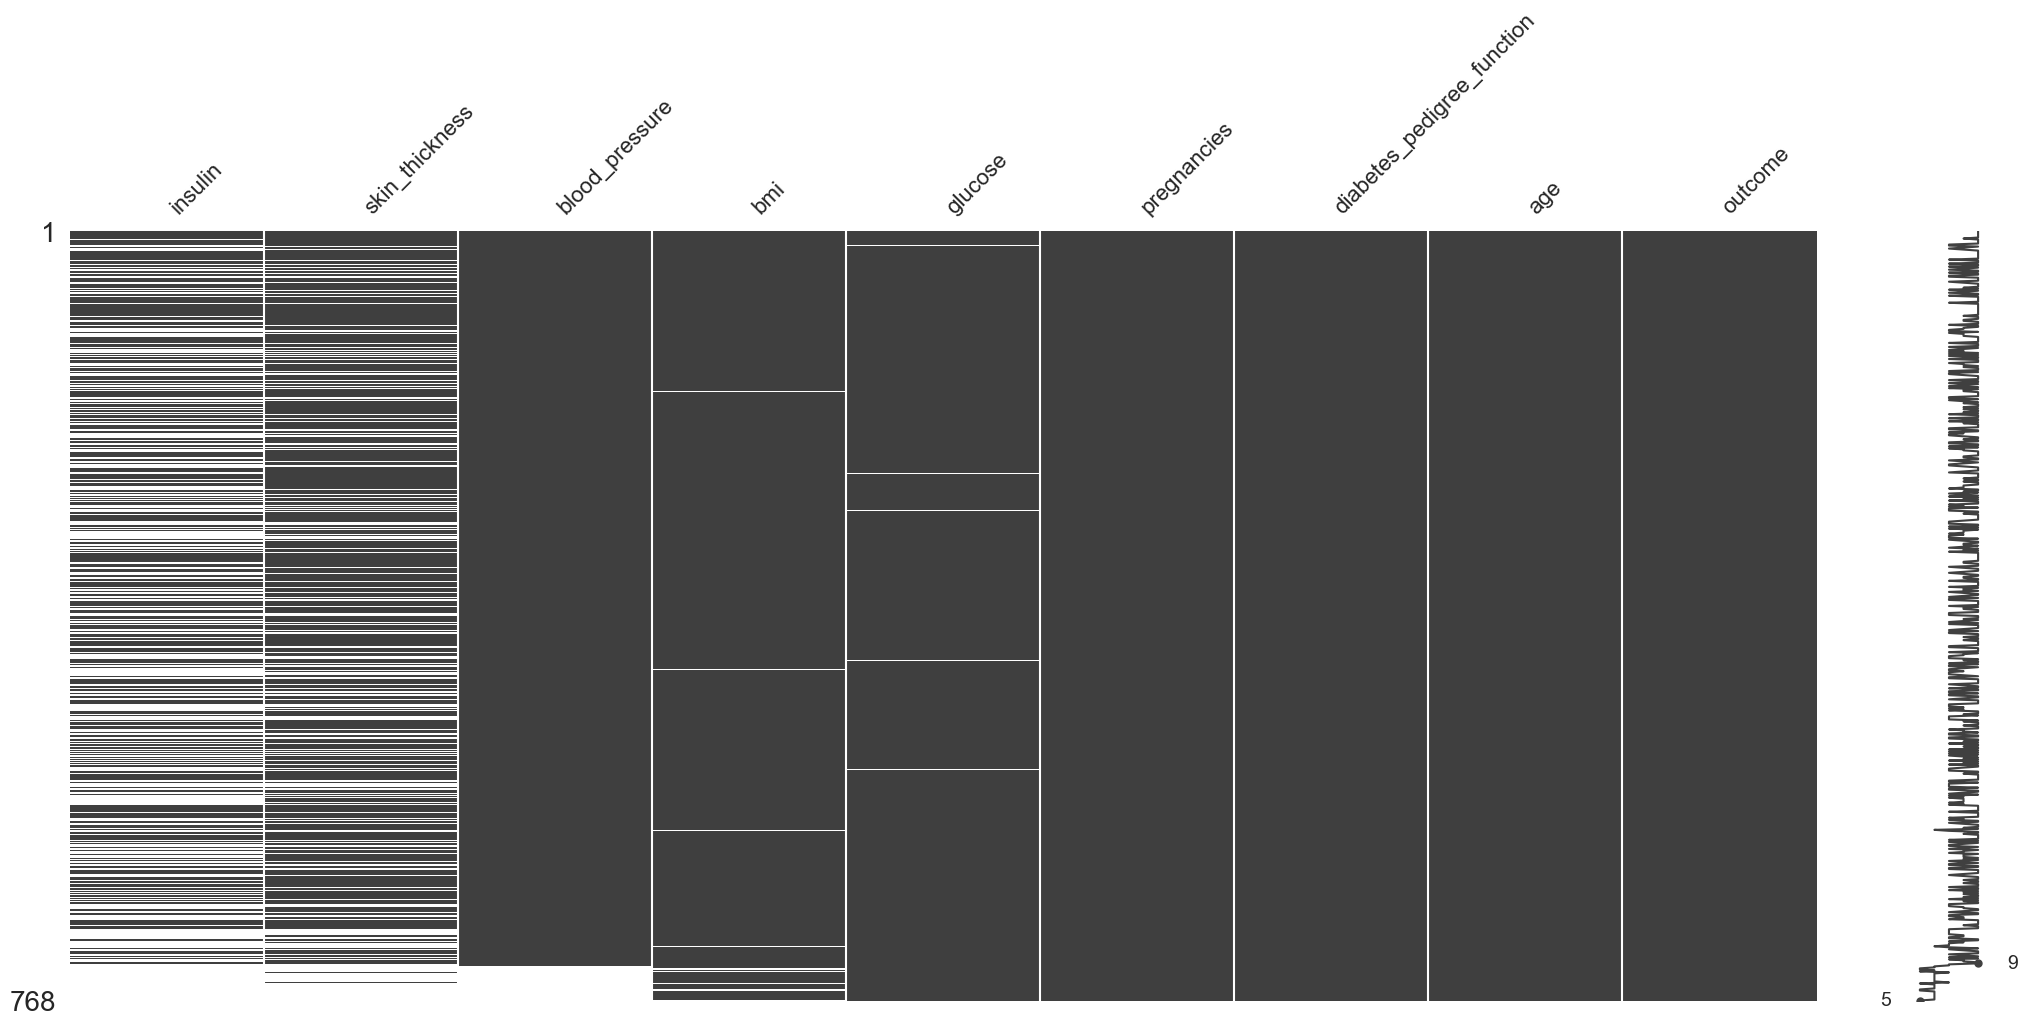

In [172]:
missingno.matrix(
    diabetes_df.sort_values(by="blood_pressure")
)

### Missing not at Random (MNAR)

Se dan debido a los límites de las herramientas, estos datos son difíciles de detectar

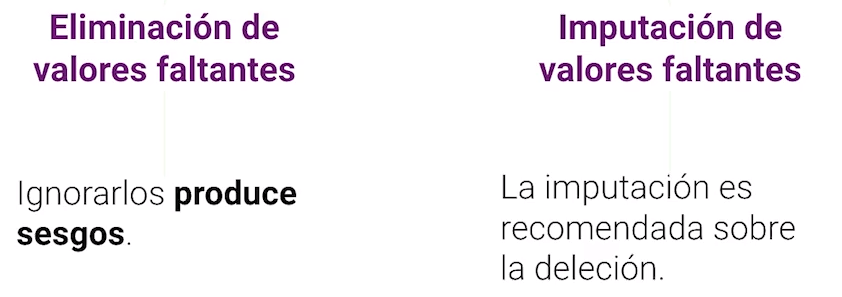

<Axes: >

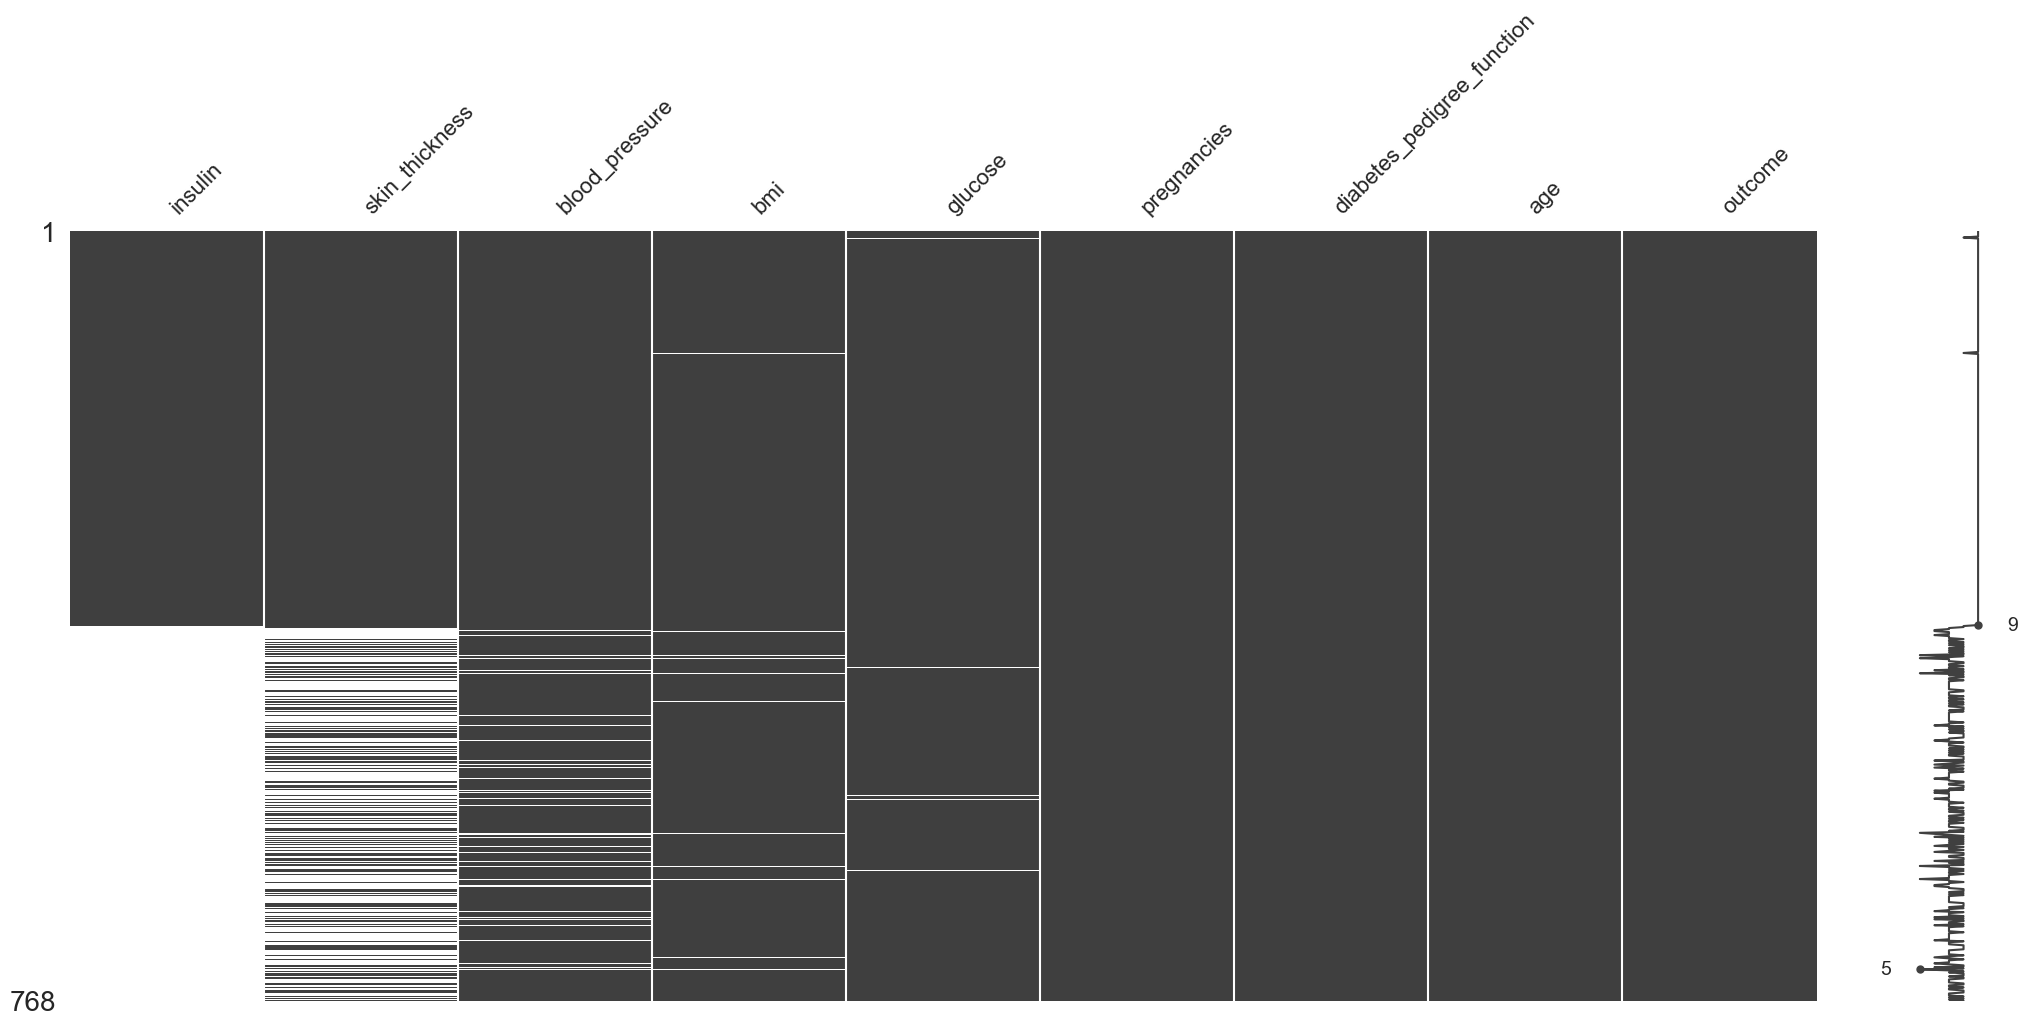

In [176]:
missingno.matrix(
    diabetes_df.sort_values(by="insulin")
)

## Matriz de sombras

Indentificar valores faltantes

Reemplazar los faltantes con booleanos o con una cadena más informativa

In [275]:
def shadow_matrix():
    return (
        riskfactors_df
        .isna() #crea una matriz de booleanos del dataframe
        .replace({ #reemplaza los valores booleanos por valores adecuados
            False:"Not missing",
            True:"Missing"
        })
        .add_suffix("_NA") #agrega un sufijo en cada variable
        .pipe(
            lambda shadow_matrix: pd.concat(  # concatena los valores de la matriz de sombra a la derecha del dataframe
                [riskfactors_df, shadow_matrix],
                axis="columns"
            )
        )
    )
    
shadow_matrix()

,state,sex,age,weight_lbs,height_inch,bmi,marital,pregnant,children,education,...,smoke_100_NA,smoke_days_NA,smoke_stop_NA,smoke_last_NA,diet_fruit_NA,diet_salad_NA,diet_potato_NA,diet_carrot_NA,diet_vegetable_NA,diet_juice_NA
0,26,Female,49,190,64,32.68,Married,NaN,0,6,...,Not missing,Missing,Missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
1,40,Female,48,170,68,25.90,Divorced,NaN,0,5,...,Not missing,Missing,Missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
2,72,Female,55,163,64,28.04,Married,NaN,0,4,...,Not missing,Missing,Missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
3,42,Male,42,230,74,29.59,Married,NaN,1,6,...,Not missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing
4,32,Female,66,135,62,24.74,Widowed,NaN,0,5,...,Not missing,Not missing,Not missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,10,Female,79,144,63,25.56,Widowed,NaN,0,4,...,Not missing,Missing,Missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
241,46,Male,45,170,74,21.87,Divorced,NaN,2,4,...,Not missing,Missing,Missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
242,15,Male,62,175,71,24.46,Divorced,NaN,0,6,...,Not missing,Not missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
243,34,Female,62,138,64,23.74,Married,NaN,0,4,...,Not missing,Not missing,Not missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing


In [278]:
(
    shadow_matrix()
    .groupby(["weight_lbs_NA"])
    ["age"]
    .describe()
)

,count,mean,std,min,25%,50%,75%,max
weight_lbs_NA,,,,,,,,
Missing,10.0,60.100000,13.706851,37.0,52.25,62.5,65.0,82.0
Not missing,235.0,58.021277,17.662904,7.0,47.50,59.0,70.0,97.0


<Axes: xlabel='weight_lbs_NA', ylabel='age'>

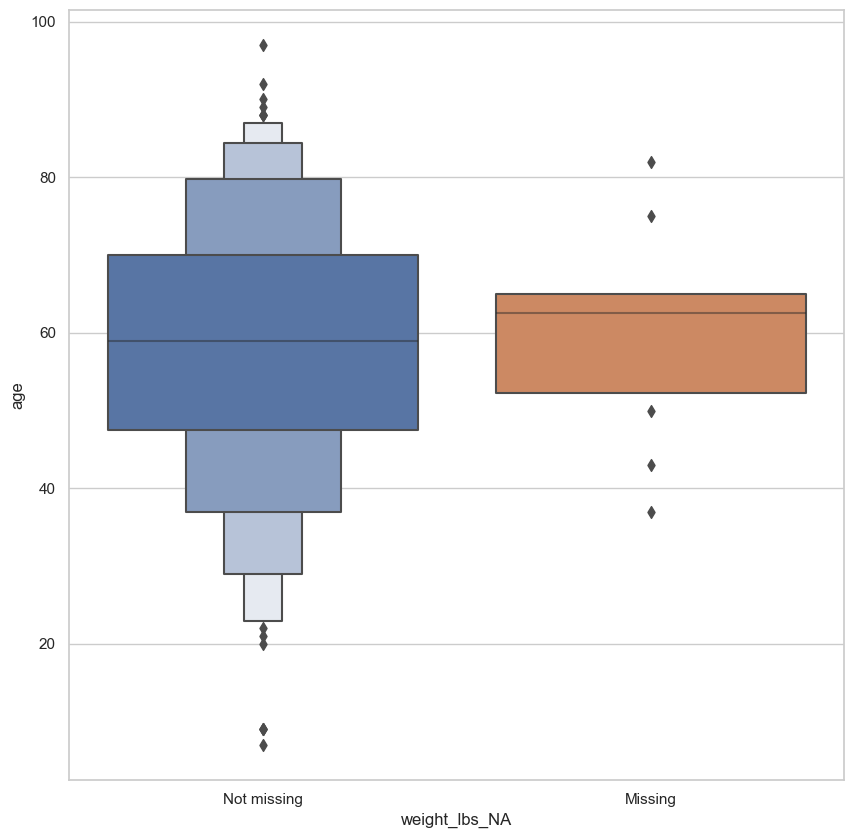

In [279]:
(
    shadow_matrix()
    .pipe(
        lambda df: (
            sns.boxenplot(
                data=df,
                x = 'weight_lbs_NA', #variables con datos faltantes
                y = 'age'  #variable de comparacion
            )
        )
    )
)

c:\Users\shani\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


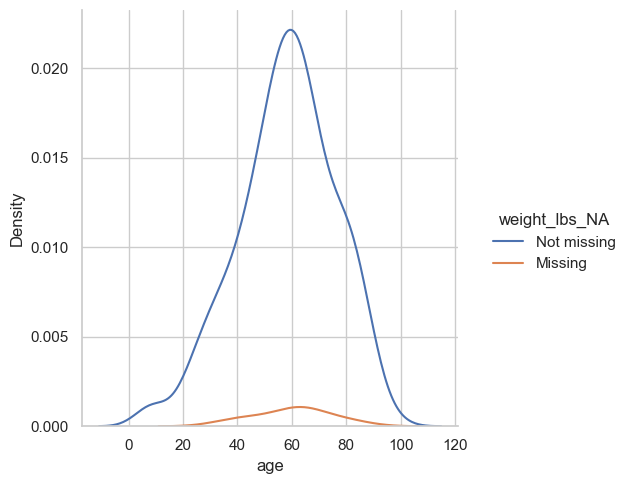

In [280]:
(
    shadow_matrix()
    .pipe(
        lambda df: (
            sns.displot(
                data=df,
                x = 'age',
                hue="weight_lbs_NA",
                kind="kde"
            )
        )
    )
)

c:\Users\shani\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


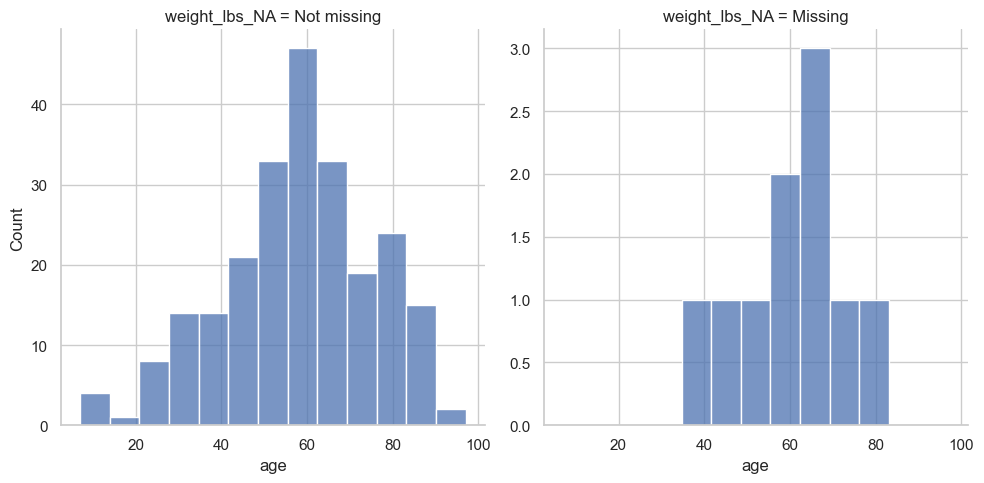

In [281]:
(
    shadow_matrix()
    .pipe(
        lambda df: (
            sns.displot(
                data=df,
                x = 'age',
                col="weight_lbs_NA",
                facet_kws= {"sharey":False}
            )
        )
    )
)

c:\Users\shani\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


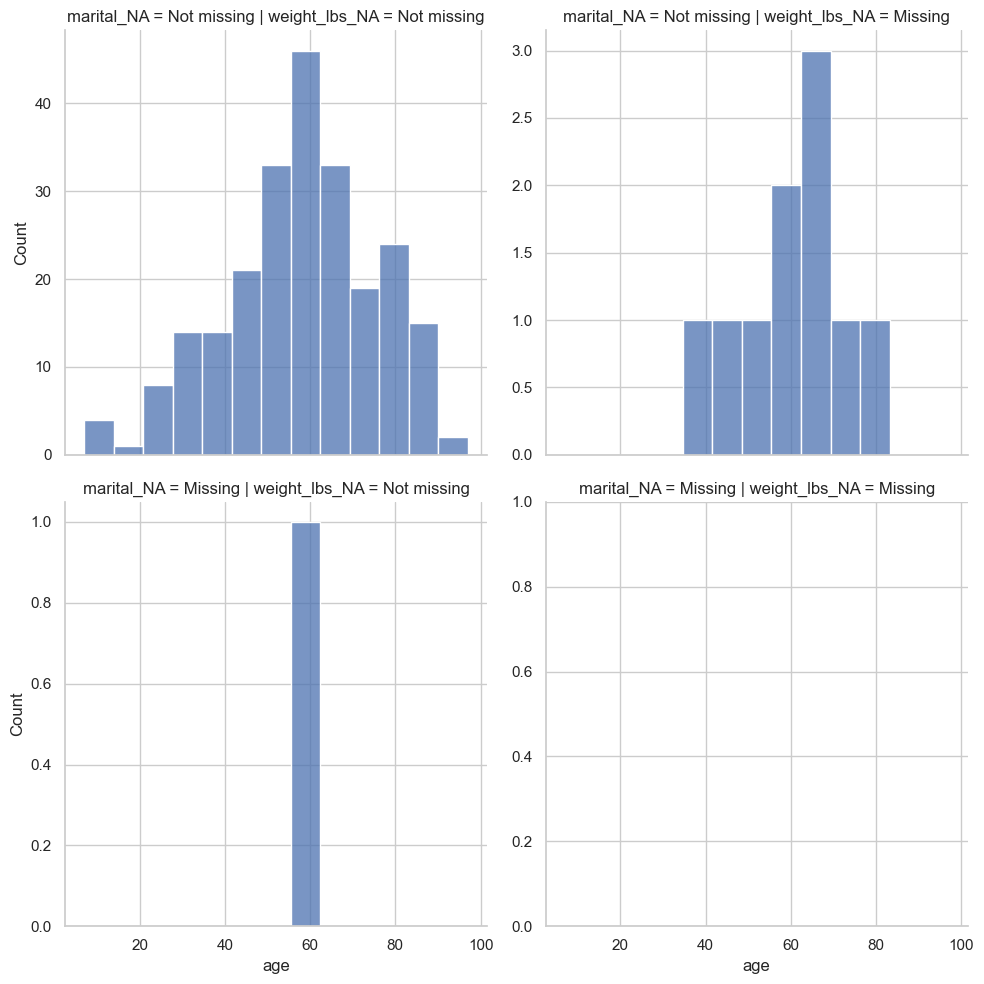

In [282]:
(
    shadow_matrix()
    .pipe(
        lambda df: (
            sns.displot(
                data=df,
                x = 'age',
                col="weight_lbs_NA",
                row="marital_NA",
                facet_kws= {"sharey":False}
            )
        )
    )
)

In [233]:
def column_fill_with_dummies(
    column: pd.Series,
    proportion_below: float=0.10,
    jitter: float=0.075,
    seed: int=42
) -> pd.Series:

    column = column.copy(deep=True)
    try:
        # Extract values metadata.
        missing_mask = column.isna()
        number_missing_values = missing_mask.sum()
        column_range = column.max() - column.min()

        # Shift data
        column_shift = column.min() - column.min() * proportion_below

        # Create the "jitter" (noise) to be added around the points.
        np.random.seed(seed)
        column_jitter = (np.random.rand(number_missing_values) - 2) * column_range * jitter

        # Save new dummy data.
        column[missing_mask] = column_shift + column_jitter
    except:
        pass
    return column

In [237]:
np.number

numpy.number

<Axes: xlabel='weight_lbs', ylabel='height_inch'>

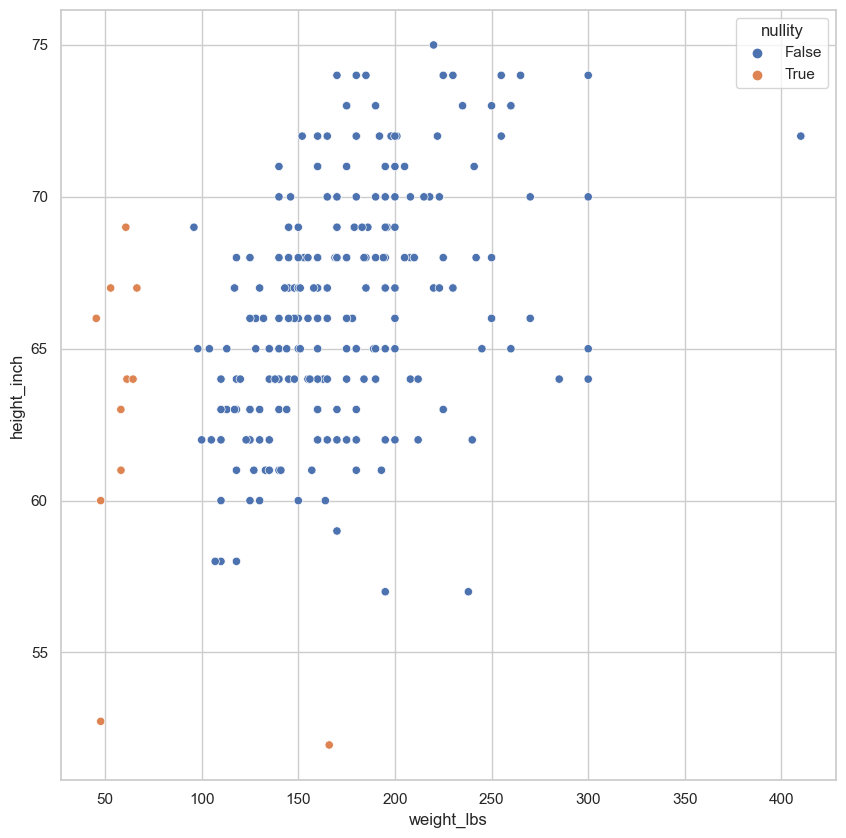

In [248]:
(
    riskfactors_df
    .select_dtypes(
        exclude='category',  # excluye las variables categoricas
        include=[object]
    )
    .pipe(
        lambda df: df[df.columns[df.isna().any()]] #seleccionar solo columnas que tengan valores faltantes
    )
    .isna() #crea una matriz de booleanos del dataframe
    # .replace({ #reemplaza los valores booleanos por valores adecuados
    #     False:"Not missing",
    #     True:"Missing"
    # })
    .add_suffix("_NA") #agrega un sufijo en cada variable
    .pipe(
        lambda shadow_matrix: pd.concat(  # concatena los valores de la matriz de sombra a la derecha del dataframe
            [riskfactors_df, shadow_matrix],
            axis="columns"
        )
    )
    .apply(
        lambda column: column if '_NA' in column.name else column_fill_with_dummies(column, proportion_below=0.05, jitter=0.075)
    )
    .assign(
        nullity = lambda df: df.weight_lbs_NA | df.height_inch_NA
    )
    .pipe(
        lambda df: (
            sns.scatterplot(
                data = df,
                x='weight_lbs',
                y= 'height_inch',
                hue='nullity'
            )
        )
    )
)

## Correlación de nulidad

Los colores azules indican una correlación de los valores faltantes de una columna con otra

<Axes: >

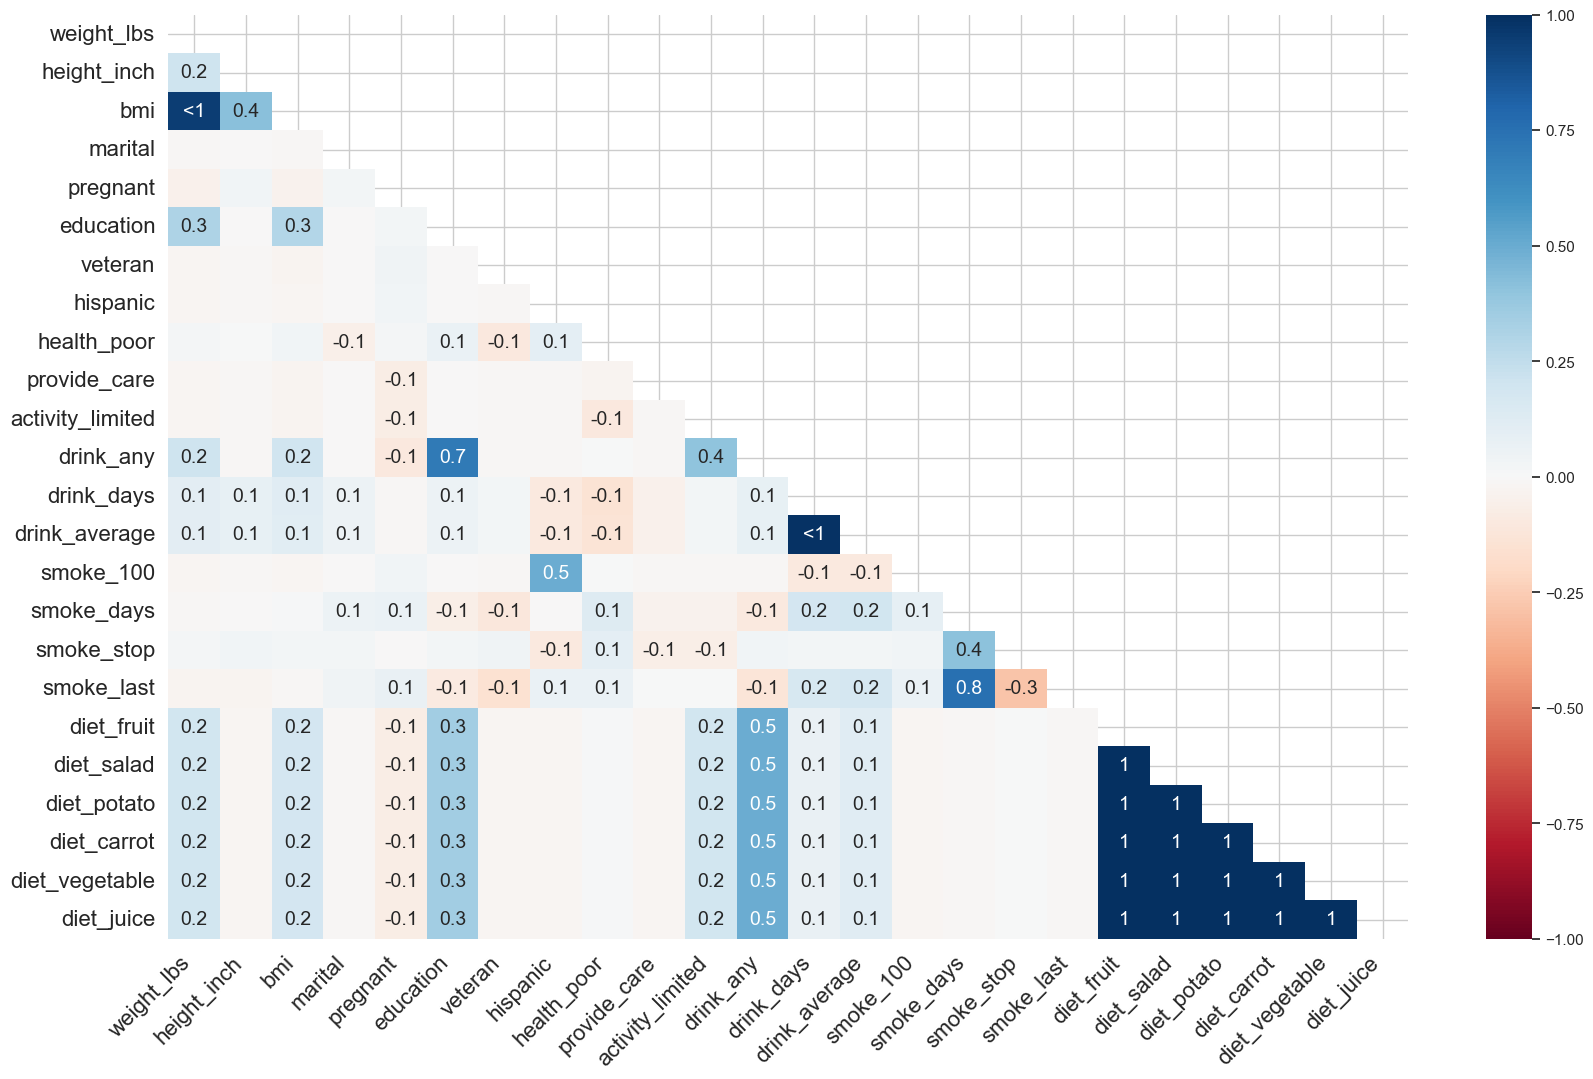

In [249]:
missingno.heatmap(
    riskfactors_df
)

<Axes: >

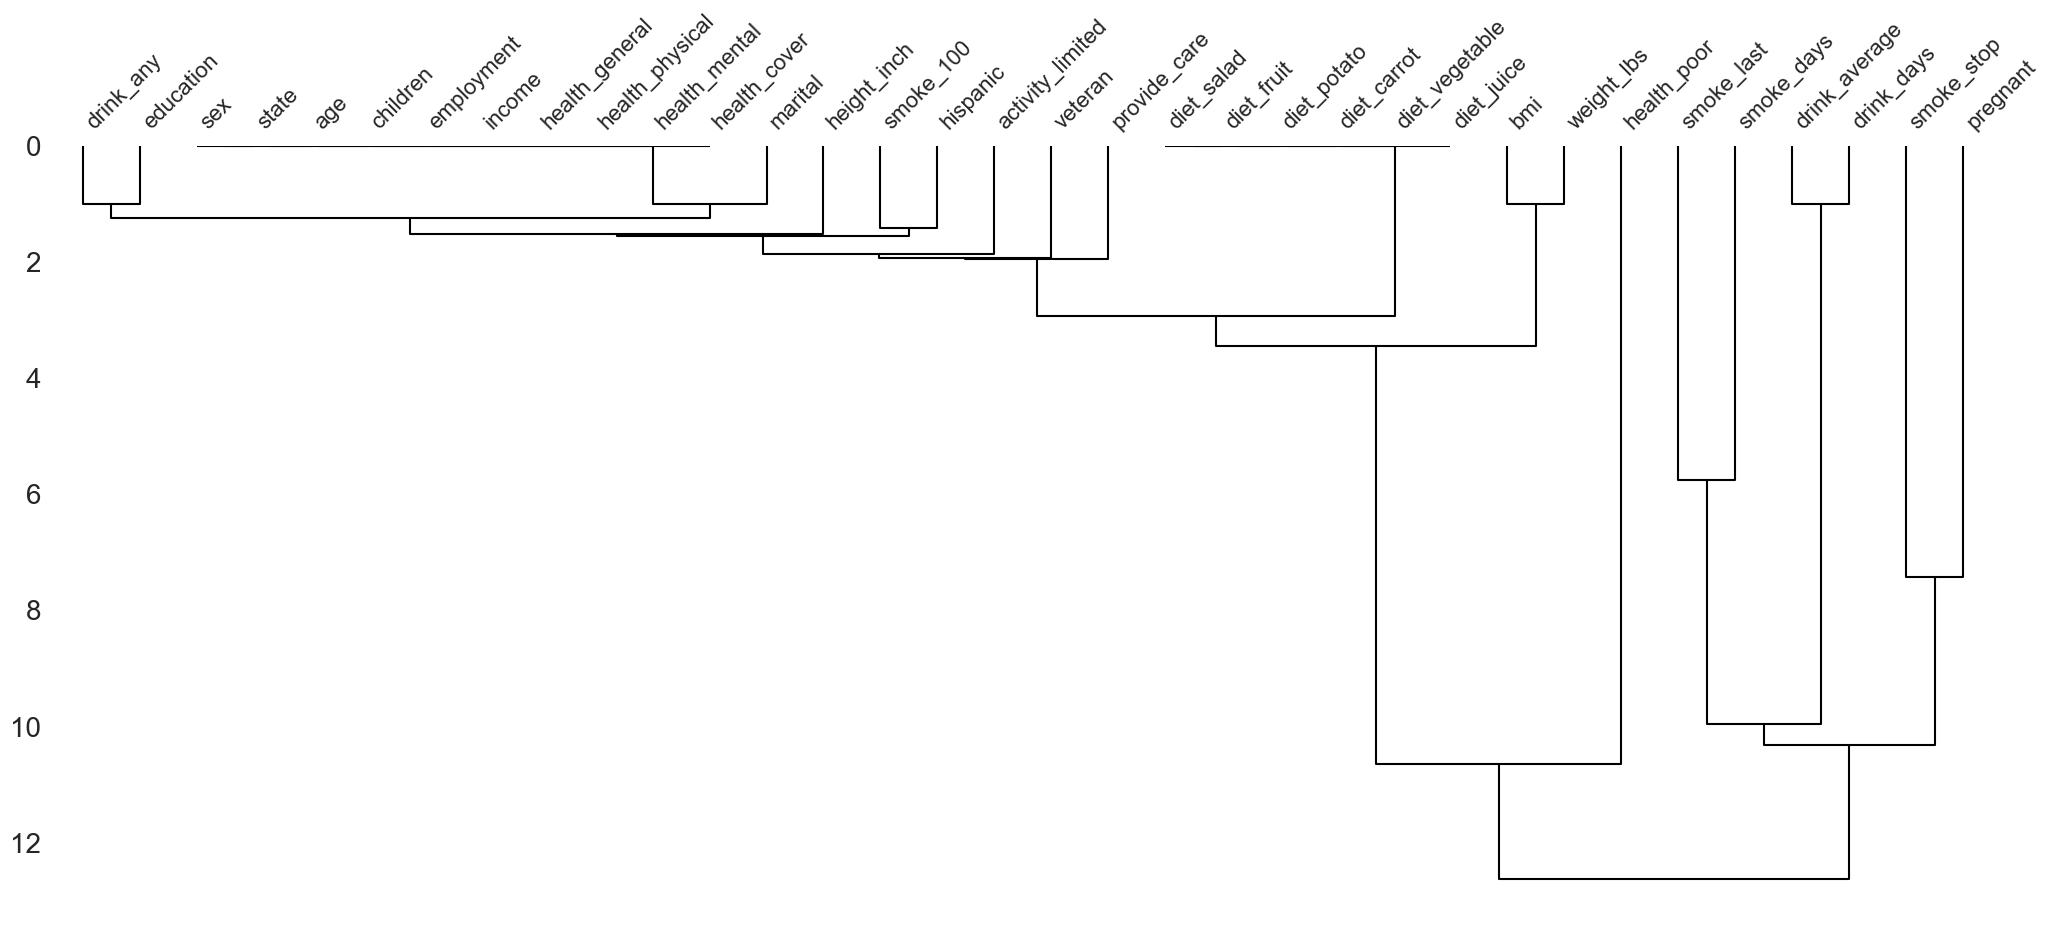

In [250]:
missingno.dendrogram(
    riskfactors_df
)

## Eliminación de valores faltantes

La eliminación de valores faltantes asume que los valores faltantes están perdidos completamente al azar (MCAR). En cualquier otro caso, realizar una eliminación de valores faltantes podrá ocasionar sesgos en los análisis y modelos subsecuentes. Por tanto, es importante investigar que mecanismos tienen los datos para asi evitar los sesgos a la hora de eliminarlos


In [253]:
riskfactors_df.shape

(245, 34)

### Pairwise deletion (eliminación por pares)

In [258]:
riskfactors_df["weight_lbs"].size, riskfactors_df["weight_lbs"].count()

(245, 235)

In [ ]:
np.mean()

In [263]:
pd.DataFrame(
    dict(
        NaN = riskfactors_df.mean(
        numeric_only=True,
        skipna=False
        ),
        NotNaN = riskfactors_df.mean(
        numeric_only=True,
        skipna=True
        )
    )
)

,NaN,NotNaN
age,58.106122,58.106122
bmi,NaN,27.784573
children,0.424490,0.424490
health_physical,4.118367,4.118367
health_mental,3.142857,3.142857


### Listwise

Con base a 1 columna

In [264]:
(
    riskfactors_df
    .dropna(
        subset=['weight_lbs'], # indica la variable donde buscar los valores faltantes
        how='any' # any indica en cualquier registro que aparezca un valor faltante
    )
)

,state,sex,age,weight_lbs,height_inch,bmi,marital,pregnant,children,education,...,smoke_100,smoke_days,smoke_stop,smoke_last,diet_fruit,diet_salad,diet_potato,diet_carrot,diet_vegetable,diet_juice
0,26,Female,49,190,64,32.68,Married,NaN,0,6,...,No,NaN,NaN,NaN,1095,261,104,156,521,12
1,40,Female,48,170,68,25.90,Divorced,NaN,0,5,...,No,NaN,NaN,NaN,52,209,52,0,52,0
2,72,Female,55,163,64,28.04,Married,NaN,0,4,...,No,NaN,NaN,NaN,36,156,52,24,24,24
3,42,Male,42,230,74,29.59,Married,NaN,1,6,...,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32,Female,66,135,62,24.74,Widowed,NaN,0,5,...,Yes,Everyday,Yes,NaN,-7,261,209,261,365,104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,10,Female,79,144,63,25.56,Widowed,NaN,0,4,...,No,NaN,NaN,NaN,-7,-7,-7,-7,-7,-7
241,46,Male,45,170,74,21.87,Divorced,NaN,2,4,...,No,NaN,NaN,NaN,52,52,52,24,52,24
242,15,Male,62,175,71,24.46,Divorced,NaN,0,6,...,Yes,Not@All,NaN,7,365,156,104,52,730,365
243,34,Female,62,138,64,23.74,Married,NaN,0,4,...,Yes,Everyday,No,NaN,730,0,24,156,104,0


Con base a dos o más columnas

In [265]:
(
    riskfactors_df
    .dropna(
        subset=['weight_lbs', 'height_inch'], # indica la variable donde buscar los valores faltantes
        how='any' # any indica en cualquier registro que aparezca un valor faltante
    )
)

,state,sex,age,weight_lbs,height_inch,bmi,marital,pregnant,children,education,...,smoke_100,smoke_days,smoke_stop,smoke_last,diet_fruit,diet_salad,diet_potato,diet_carrot,diet_vegetable,diet_juice
0,26,Female,49,190,64,32.68,Married,NaN,0,6,...,No,NaN,NaN,NaN,1095,261,104,156,521,12
1,40,Female,48,170,68,25.90,Divorced,NaN,0,5,...,No,NaN,NaN,NaN,52,209,52,0,52,0
2,72,Female,55,163,64,28.04,Married,NaN,0,4,...,No,NaN,NaN,NaN,36,156,52,24,24,24
3,42,Male,42,230,74,29.59,Married,NaN,1,6,...,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32,Female,66,135,62,24.74,Widowed,NaN,0,5,...,Yes,Everyday,Yes,NaN,-7,261,209,261,365,104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,10,Female,79,144,63,25.56,Widowed,NaN,0,4,...,No,NaN,NaN,NaN,-7,-7,-7,-7,-7,-7
241,46,Male,45,170,74,21.87,Divorced,NaN,2,4,...,No,NaN,NaN,NaN,52,52,52,24,52,24
242,15,Male,62,175,71,24.46,Divorced,NaN,0,6,...,Yes,Not@All,NaN,7,365,156,104,52,730,365
243,34,Female,62,138,64,23.74,Married,NaN,0,4,...,Yes,Everyday,No,NaN,730,0,24,156,104,0


In [267]:
# elimina los registros en los que hayan valores faltantes en dos variables al mismo tiempo
(
    riskfactors_df
    .dropna(
        subset=['weight_lbs', 'height_inch'], # indica el parametro donde buscar los valores faltantes
        how='all' # all indica los registros donde hayan valores faltantes en ambas variables
    )
)

,state,sex,age,weight_lbs,height_inch,bmi,marital,pregnant,children,education,...,smoke_100,smoke_days,smoke_stop,smoke_last,diet_fruit,diet_salad,diet_potato,diet_carrot,diet_vegetable,diet_juice
0,26,Female,49,190,64,32.68,Married,NaN,0,6,...,No,NaN,NaN,NaN,1095,261,104,156,521,12
1,40,Female,48,170,68,25.90,Divorced,NaN,0,5,...,No,NaN,NaN,NaN,52,209,52,0,52,0
2,72,Female,55,163,64,28.04,Married,NaN,0,4,...,No,NaN,NaN,NaN,36,156,52,24,24,24
3,42,Male,42,230,74,29.59,Married,NaN,1,6,...,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32,Female,66,135,62,24.74,Widowed,NaN,0,5,...,Yes,Everyday,Yes,NaN,-7,261,209,261,365,104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,10,Female,79,144,63,25.56,Widowed,NaN,0,4,...,No,NaN,NaN,NaN,-7,-7,-7,-7,-7,-7
241,46,Male,45,170,74,21.87,Divorced,NaN,2,4,...,No,NaN,NaN,NaN,52,52,52,24,52,24
242,15,Male,62,175,71,24.46,Divorced,NaN,0,6,...,Yes,Not@All,NaN,7,365,156,104,52,730,365
243,34,Female,62,138,64,23.74,Married,NaN,0,4,...,Yes,Everyday,No,NaN,730,0,24,156,104,0


<Axes: >

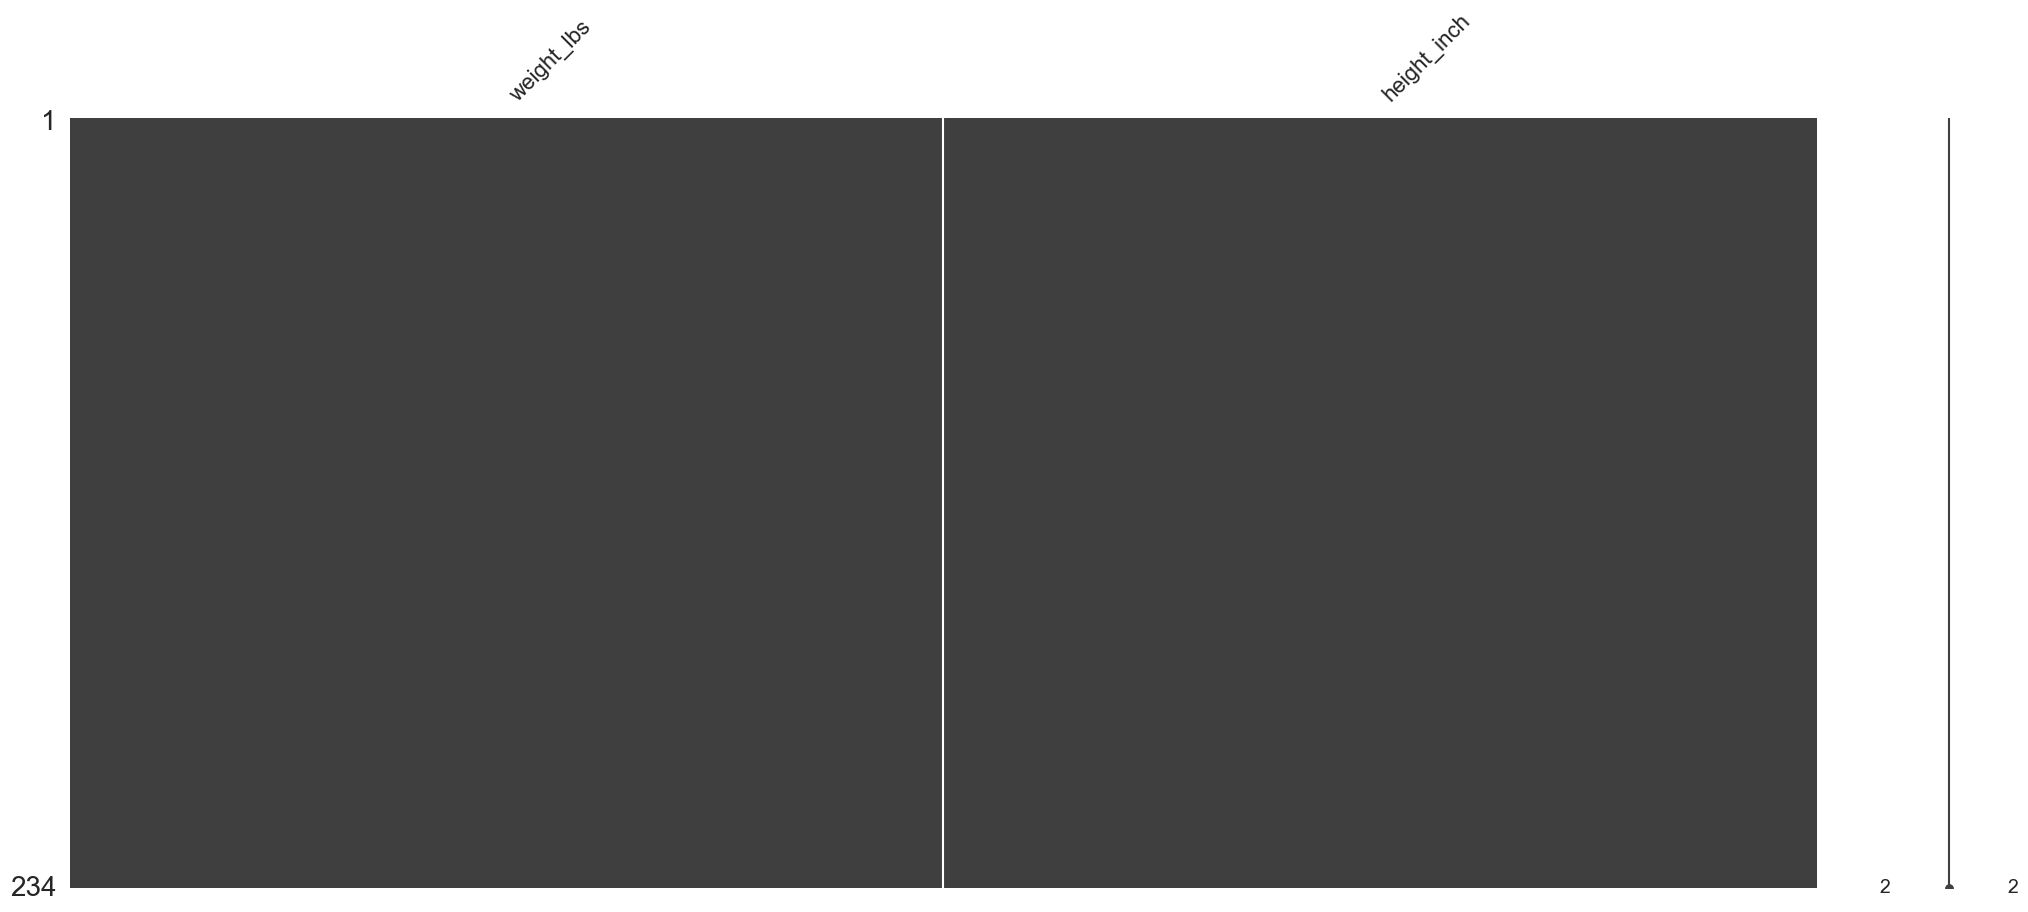

In [268]:
(
    riskfactors_df
    .dropna(
        subset=['weight_lbs', 'height_inch'], # indica el parametro donde buscar los valores faltantes
        how='any' # any indica en cualquier registro que aparezca un valor faltante
    )
    .select_columns(['weight_lbs', 'height_inch'])
    .pipe(missingno.matrix)
)

<Axes: >

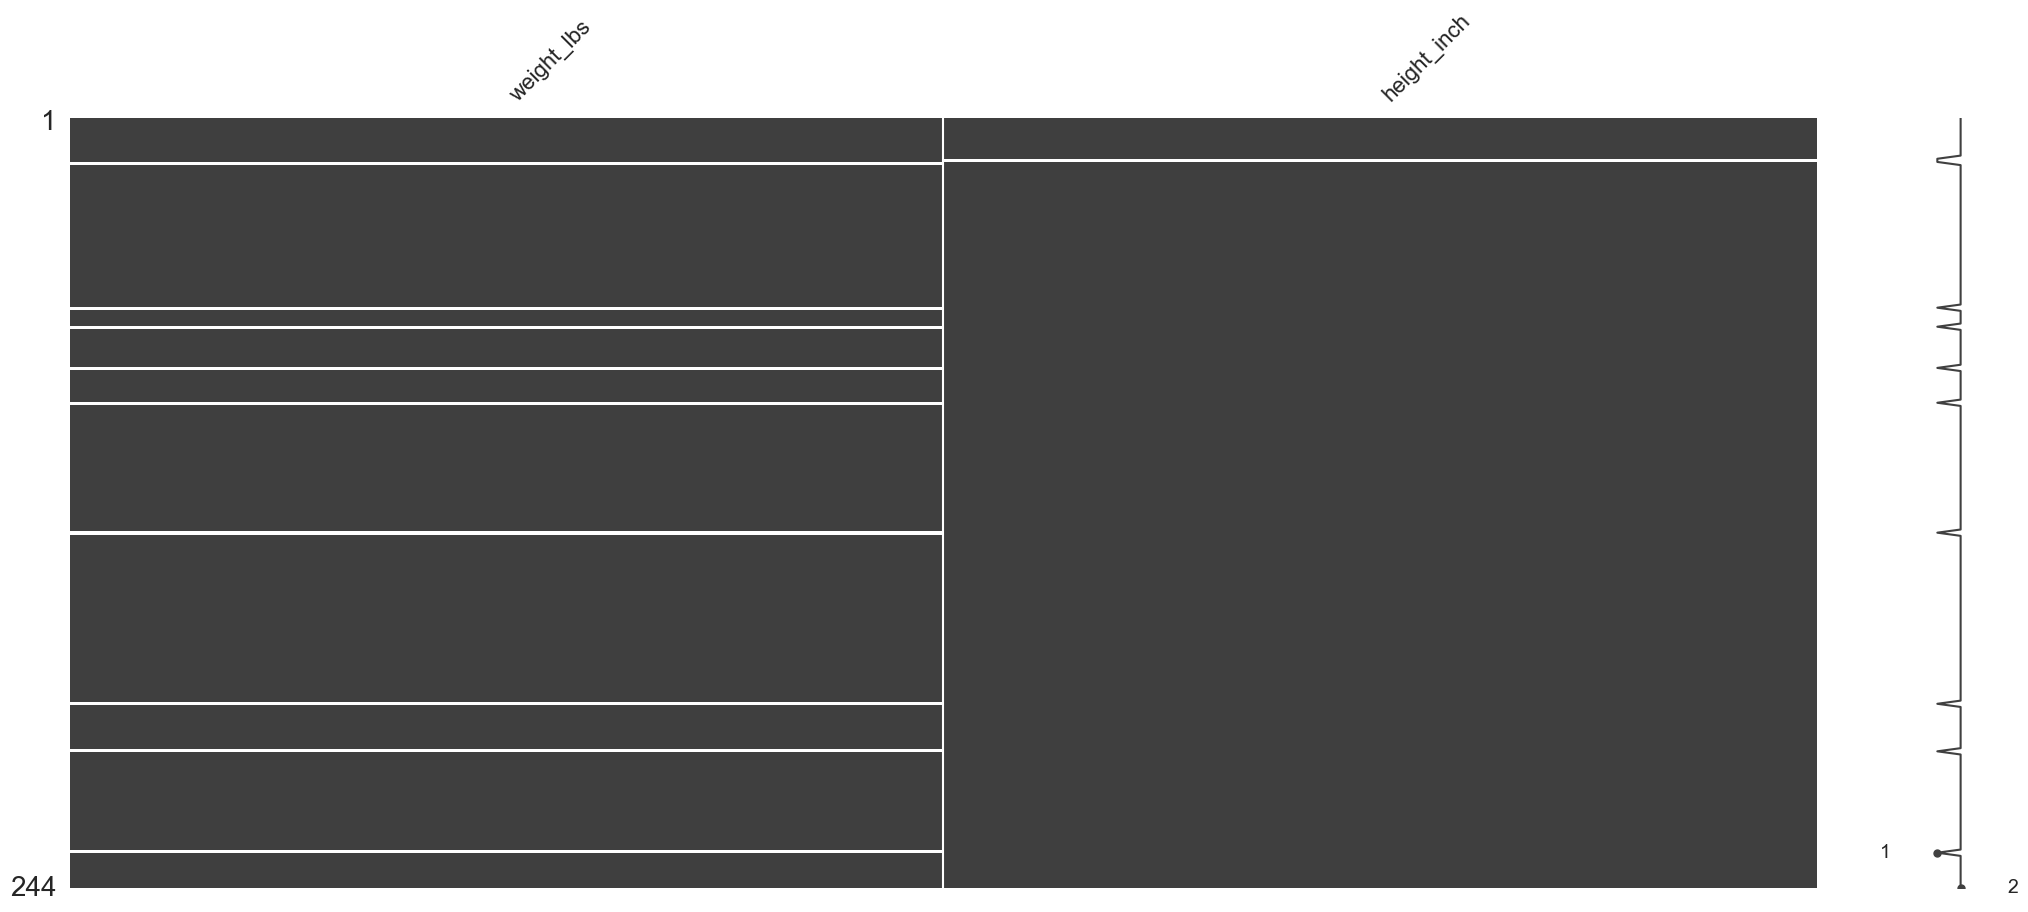

In [269]:
(
    riskfactors_df
    .dropna(
        subset=['weight_lbs', 'height_inch'], # indica el parametro donde buscar los valores faltantes
        how='all' # algoritmo con el que eliminar los registros
    )
    .select_columns(['weight_lbs', 'height_inch'])
    .pipe(missingno.matrix)
)

# Imputacion de valores faltantes
Consiste en añadir valores en los datos faltantes para mantener el registro en el dataset

Con base en el contexto

In [270]:
implicit_to_explicit_df = pd.DataFrame(
    data={
        "name": ["lynn", np.nan, "zelda", np.nan, "shadowsong", np.nan],
        "time": ["morning", "afternoon", "morning", "afternoon", "morning", "afternoon",],
        "value": [350, 310, 320, 350, 310, 320]
    }
)

implicit_to_explicit_df

,name,time,value
0,lynn,morning,350
1,NaN,afternoon,310
2,zelda,morning,320
3,NaN,afternoon,350
4,shadowsong,morning,310
5,NaN,afternoon,320


In [271]:
implicit_to_explicit_df.ffill()

,name,time,value
0,lynn,morning,350
1,lynn,afternoon,310
2,zelda,morning,320
3,zelda,afternoon,350
4,shadowsong,morning,310
5,shadowsong,afternoon,320


De un único valor

c:\Users\shani\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


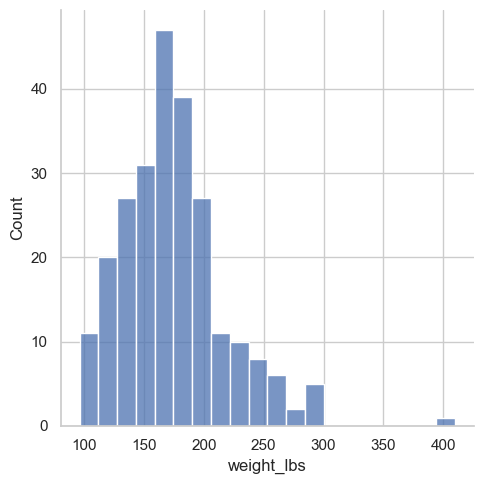

In [288]:
(
    shadow_matrix()
    .select_columns('weight_lbs', 'height_inch', 'bmi')
    .apply(
        axis = "rows",
        func = lambda column: column.fillna(column.mean()) if "_NA" not in column.name else column
    )
    .pipe(
        lambda df:(
            sns.displot(
                df,
                x='weight_lbs',
                # hue='weight_lbs_NA'
            )
        )
    )
)


In [293]:
(
    shadow_matrix()
    .select_columns("weight_lbs","height_inch","bmi")
    .apply(
        axis="rows",
        func = lambda column : column.fillna(column.mean()) if "_NA" not in column.name else column
    )
    .pivot_longer(
        index="*_NA"
    )
    .pivot_longer(
        index=["variable","value"],
        names_to="variable_NA",
        values_to="value_NA"
    )
    .assign(
        valid=lambda df : df.apply(axis="columns", func= lambda column : column.variable in column.variable_NA)
    )
    .query("valid")
    .pipe(
        lambda df:(
            sns.displot(
                data=df,
                x="value",
                hue="value_NA",
                col="variable",
                common_bins=False,
                facet_kws={
                    "sharex":False,
                    "sharey":False
                }
            )
        )
    )
)

KeyError: "No match was returned for '*_NA'"